<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 10px 20px rgba(0,0,0,0.19), 0 6px 6px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 800; font-size: 2.5em; color: white; text-shadow: 2px 2px 4px #000;">✨ IMPORTS ✨</span>
</div>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score
import pickle
from collections import defaultdict
from sklearn.utils import shuffle
import os
import cv2
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd

from torchinfo import summary
from sklearn.metrics import confusion_matrix
import seaborn as sns



<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 10px 20px rgba(0,0,0,0.19), 0 6px 6px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 800; font-size: 2.5em; color: white; text-shadow: 2px 2px 4px #000;">✨ LOADING THE SPLIT DATA ARRAYS ✨</span>
</div>

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">📁 reminder to change the folder path to your numpy array folder 📁</span>
</div>

In [2]:
import numpy as np
import os

# Define the folder path
folder_path = r"D:\PYTHONIG\newwindow\NOTEBOOKS_2025\aprilmay2025\data\numpy\cwtnormalized\concatenatedspectrograms"

# Load the numpy files into the respective arrays with the correct capitalized naming
eeg_fold_1 = np.load(os.path.join(folder_path, 'CWT_DATA_FOLD_fold_1.npy'))
labels_fold_1 = np.load(os.path.join(folder_path, 'CWT_LABELS_FOLD_fold_1.npy'))
patients_fold_1 = np.load(os.path.join(folder_path, 'CWT_PATIENTS_FOLD_fold_1.npy'))

eeg_fold_2 = np.load(os.path.join(folder_path, 'CWT_DATA_FOLD_fold_2.npy'))
labels_fold_2 = np.load(os.path.join(folder_path, 'CWT_LABELS_FOLD_fold_2.npy'))
patients_fold_2 = np.load(os.path.join(folder_path, 'CWT_PATIENTS_FOLD_fold_2.npy'))

eeg_fold_3 = np.load(os.path.join(folder_path, 'CWT_DATA_FOLD_fold_3.npy'))
labels_fold_3 = np.load(os.path.join(folder_path, 'CWT_LABELS_FOLD_fold_3.npy'))
patients_fold_3 = np.load(os.path.join(folder_path, 'CWT_PATIENTS_FOLD_fold_3.npy'))

eeg_fold_4 = np.load(os.path.join(folder_path, 'CWT_DATA_FOLD_fold_4.npy'))
labels_fold_4 = np.load(os.path.join(folder_path, 'CWT_LABELS_FOLD_fold_4.npy'))
patients_fold_4 = np.load(os.path.join(folder_path, 'CWT_PATIENTS_FOLD_fold_4.npy'))

eeg_fold_5 = np.load(os.path.join(folder_path, 'CWT_DATA_FOLD_fold_5.npy'))
labels_fold_5 = np.load(os.path.join(folder_path, 'CWT_LABELS_FOLD_fold_5.npy'))
patients_fold_5 = np.load(os.path.join(folder_path, 'CWT_PATIENTS_FOLD_fold_5.npy'))

eeg_folds = [eeg_fold_1, eeg_fold_2, eeg_fold_3, eeg_fold_4, eeg_fold_5]
labels_folds = [labels_fold_1, labels_fold_2, labels_fold_3, labels_fold_4, labels_fold_5]
patients_folds = [patients_fold_1, patients_fold_2, patients_fold_3, patients_fold_4, patients_fold_5]

for i in range(len(eeg_folds)):
    eeg_folds[i] = eeg_folds[i].astype(np.float16)

In [3]:
eeg_fold_1.shape

(1095, 224, 224, 3)

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">data balancer & early stopping</span>
</div>

In [4]:
def data_balancer(data, labels, factor):
    # Count the number of samples in each class
    num_class_0 = np.sum(labels == 0)
    num_class_1 = np.sum(labels == 1)
    num_class_2 = np.sum(labels == 2)

    # Find the minimum number of samples across all classes
    min_samples = min(num_class_0, num_class_1, num_class_2)

    # Calculate the number of samples to take from each class
    samples_per_class = min_samples // factor

    # Randomly sample 'samples_per_class' from each class
    class_0_indices = np.random.choice(np.where(labels == 0)[0], samples_per_class, replace=False)
    class_1_indices = np.random.choice(np.where(labels == 1)[0], samples_per_class, replace=False)
    class_2_indices = np.random.choice(np.where(labels == 2)[0], samples_per_class, replace=False)

    # Combine balanced indices
    balanced_indices = np.concatenate((class_0_indices, class_1_indices, class_2_indices))

    # Shuffle the balanced indices
    np.random.shuffle(balanced_indices)

    # Create balanced training data and labels
    balanced_data = data[balanced_indices]
    balanced_labels = labels[balanced_indices]

    return balanced_data, balanced_labels

In [5]:
class EarlyStopping:
    def __init__(self, patience=5):
        """
        Initializes the early stopping mechanism based on divergence detection.

        Args:
            patience (int): Number of consecutive epochs with increasing validation loss
                            before stopping.
        """
        self.patience = patience
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        """
        Checks if the validation loss is diverging and updates the state accordingly.

        Args:
            val_loss (float): Current epoch's validation loss.
            model (torch.nn.Module): The model being trained.
        """
        if self.best_loss is None or val_loss < self.best_loss:
            # Improvement detected
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0
        else:
            # Validation loss increased
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Divergence detected. Stopping training after {self.counter} epochs.")
                self.early_stop = True

    def load_best_model(self, model):
        """
        Restores the model to the state with the lowest validation loss.

        Args:
            model (torch.nn.Module): The model to restore.
        """
        model.load_state_dict(self.best_model_state)




<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Result plotting</span>
</div>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    auc,
    f1_score,
    balanced_accuracy_score,
    classification_report,
)
from sklearn.preprocessing import label_binarize

def plot_metrics(labels, predictions, n_classes=3):
    """
    Plots and computes metrics for classification tasks.

    Args:
        labels (array-like): True labels.
        predictions (array-like): Predicted probabilities or class predictions.
        n_classes (int): Number of classes (default is 3 for multi-class classification).
    """
    # If predictions are probabilities, convert to class predictions
    if predictions.ndim > 1:
        predicted_classes = np.argmax(predictions, axis=1)
    else:
        predicted_classes = predictions

    # Confusion Matrix
    cm = confusion_matrix(labels, predicted_classes)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Class-wise Accuracy
    print("\nClass-wise Accuracy:")
    for d in range(n_classes):
        correct_preds = cm[d][d]
        total_true_samples = sum(cm[d])
        ratio_correct = correct_preds / total_true_samples if total_true_samples != 0 else 0
        print(f'Class {d}: Correct Predictions / Total True Samples = {correct_preds}/{total_true_samples} ({ratio_correct:.2%})')

    # Precision-Recall Curves and AUPRC
    print("\nPrecision-Recall Curves:")
    labels_binarized = label_binarize(labels, classes=np.arange(n_classes))
    auprcs = []
    for class_idx in range(n_classes):
        precision, recall, _ = precision_recall_curve(labels_binarized[:, class_idx], predictions[:, class_idx])
        auprc = auc(recall, precision)
        auprcs.append(auprc)
        plt.plot(recall, precision, label=f'Class {class_idx + 1} (AUPRC = {auprc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves for each class')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # ROC Curves and AUC
    print("\nROC Curves:")
    for class_idx in range(n_classes):
        fpr, tpr, _ = roc_curve(labels_binarized[:, class_idx], predictions[:, class_idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_idx + 1} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for each class')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # Mean F1 Score
    f1 = f1_score(labels, predicted_classes, average='macro')
    print(f"\nMean F1 Score: {f1:.4f}")

    # Balanced Accuracy
    balanced_acc = balanced_accuracy_score(labels, predicted_classes)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    # Average AUPRC
    mean_auprc = np.mean(auprcs)
    print(f"Average AUPRC: {mean_auprc:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(labels, predicted_classes))

    return {
        "confusion_matrix": cm,
        "class_wise_accuracy": [cm[d][d] / sum(cm[d]) if sum(cm[d]) != 0 else 0 for d in range(n_classes)],
        "mean_f1_score": f1,
        "balanced_accuracy": balanced_acc,
        "average_auprc": mean_auprc,
        "auprc_per_class": auprcs,
    }

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">MODEL GOES HERE</span>
</div>

In [7]:
debug_mode_flag = False
import torch
import torch.nn as nn

class CustomCnn(nn.Module):
    def __init__(self, debug_mode_flag=False):
        super().__init__()
        self.debug_mode_flag = debug_mode_flag
        
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces spatial size
        )
        
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Further reduces spatial size
        )

        # Global Average Pooling to reduce spatial dimensions 
        self.global_avg_pool = nn.AdaptiveAvgPool2d((8, 8))  # Keeps a manageable seq_len
        self.flatten = nn.Flatten(start_dim=2)  # Keeps batch & channel dims

    def forward(self, x):
        if self.debug_mode_flag: print(f"Input shape: {x.shape}")
        
        x = self.block_1(x)
        if self.debug_mode_flag: print(f"Block 1 shape: {x.shape}")
        
        x = self.block_2(x)
        if self.debug_mode_flag: print(f"Block 2 shape: {x.shape}")
        
        x = self.global_avg_pool(x)  # (batch, 128, 8, 8)
        if self.debug_mode_flag: print(f"Global Avg Pool shape: {x.shape}")

        # x = self.flatten(x)  # (batch, 128, 64)
        # if self.debug_mode_flag: print(f"Flattened shape (Transformer Input): {x.shape}")
        
        return x

    
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.att = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x):
        attn_output, _ = self.att(x, x, x)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)
    
class TRANS_CNN(nn.Module):
    def __init__(self, input_shape, num_classes, embed_dim=512, num_heads=2, ff_dim=64, num_transformer_blocks=4):
        
        super(TRANS_CNN,self).__init__()
        
        self.num_transformer_blocks = num_transformer_blocks
        self.cnn_extractor = CustomCnn()
        
        self.projection = nn.Linear(512, embed_dim)
        
        self.encoder = nn.ModuleList([
            TransformerEncoder(embed_dim,num_heads,ff_dim) for _ in range(num_transformer_blocks)
        ])
        
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.1)
        
        self.precls = nn.Linear(embed_dim,embed_dim)
        self.precls2 = nn.Linear(embed_dim,embed_dim)
        self.precls3 = nn.Linear(embed_dim,embed_dim//4)
        
        self.clf = nn.Linear(embed_dim//4,num_classes)
        
        
    def forward(self,x):
        
        x = self.cnn_extractor(x)
        if debug_mode_flag: print(f"x shape after cnn extraction = {x.shape}")
        
        B,C,H,W = x.shape
        
        x = x.view(B,H*W,C)
        if debug_mode_flag: print(f"x shape after changing view= {x.shape}")
        
        # x = self.projection(x)
        # if debug_mode_flag: print(f"x shape after projection= {x.shape}")
        
        for encoderblock in self.encoder:
            x = encoderblock(x)
            
        if debug_mode_flag: print(f"x shape after passing thru encoder= {x.shape}")
        
        x = x.permute(1,0,2)
        if debug_mode_flag: print(f"x shape after permuting{x.shape}")
        
        x = self.precls3(x)
        if debug_mode_flag: print(f"precls3 {x.shape}")
        
        x = self.dropout(x)
        
        x = x.mean(dim=0)  # Global average pooling over sequence (9 tokens → 1 token)
        if debug_mode_flag: print(f"x shape after average pooling {x.shape}")

        x = self.clf(x)  #they see me rolling
        if debug_mode_flag: print(f"cls {x.shape}")
        
        
        return x

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Test with demo data & model Summary</span>
</div>

In [8]:
model  = TRANS_CNN(input_shape=(224,224,3),num_classes=3,num_transformer_blocks=4,embed_dim=128) # declare model here
randomdata = torch.randn((1,3,224,224))
output = model(randomdata)
output.shape

torch.Size([1, 3])

In [9]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                       Param #
TRANS_CNN                                                    --
├─CustomCnn: 1-1                                             --
│    └─Sequential: 2-1                                       --
│    │    └─Conv2d: 3-1                                      448
│    │    └─BatchNorm2d: 3-2                                 32
│    │    └─ReLU: 3-3                                        --
│    │    └─Conv2d: 3-4                                      4,640
│    │    └─BatchNorm2d: 3-5                                 64
│    │    └─ReLU: 3-6                                        --
│    │    └─MaxPool2d: 3-7                                   --
│    └─Sequential: 2-2                                       --
│    │    └─Conv2d: 3-8                                      18,496
│    │    └─BatchNorm2d: 3-9                                 128
│    │    └─ReLU: 3-10                                       --
│    │    └─Conv2d: 3-11  

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Training Code</span>
</div>

__________________________________________________
__________________________________________________
__________________________________________________
PARAMS SET 0
__________________________________________________
__________________________________________________
__________________________________________________
__________________________________________________
Fold No: 1
training on folds: [[np.int64(4), np.int64(2), np.int64(0)]]
validation on folds: 3
test on folds: 1
Epoch [1/100], Loss: 1.1037, Accuracy: 0.3401 | Validation Loss: 1.0887, Validation Accuracy: 0.3305
Epoch [2/100], Loss: 1.0920, Accuracy: 0.3911 | Validation Loss: 1.1496, Validation Accuracy: 0.3525
Epoch [3/100], Loss: 1.0885, Accuracy: 0.4094 | Validation Loss: 1.1249, Validation Accuracy: 0.3813
Epoch [4/100], Loss: 1.0811, Accuracy: 0.4441 | Validation Loss: 1.1070, Validation Accuracy: 0.3825
Epoch [5/100], Loss: 1.0777, Accuracy: 0.4364 | Validation Loss: 1.0848, Validation Accuracy: 0.3859
Epoch [6/100]

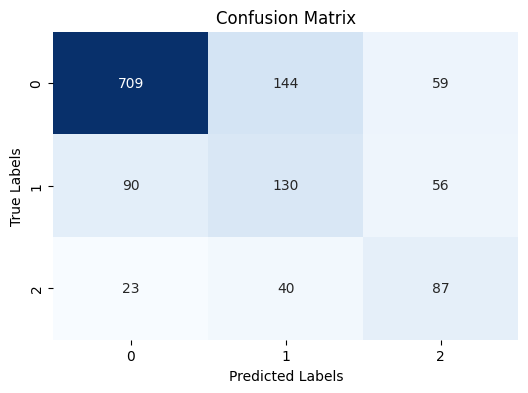


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 709/912 (77.74%)
Class 1: Correct Predictions / Total True Samples = 130/276 (47.10%)
Class 2: Correct Predictions / Total True Samples = 87/150 (58.00%)

Precision-Recall Curves:


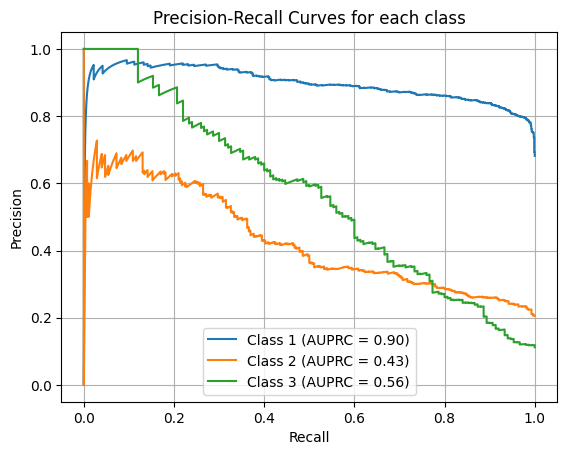


ROC Curves:


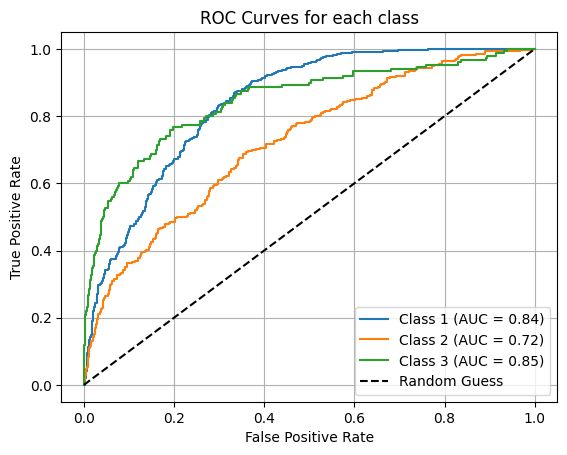


Mean F1 Score: 0.5843
Balanced Accuracy: 0.6095
Average AUPRC: 0.6293

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       912
           1       0.41      0.47      0.44       276
           2       0.43      0.58      0.49       150

    accuracy                           0.69      1338
   macro avg       0.57      0.61      0.58      1338
weighted avg       0.72      0.69      0.70      1338

__________________________________________________
Fold No: 2
training on folds: [[np.int64(2), np.int64(0), np.int64(3)]]
validation on folds: 1
test on folds: 4
Epoch [1/100], Loss: 1.1028, Accuracy: 0.3265 | Validation Loss: 1.0885, Validation Accuracy: 0.3520
Epoch [2/100], Loss: 1.0958, Accuracy: 0.3745 | Validation Loss: 1.0965, Validation Accuracy: 0.4101
Epoch [3/100], Loss: 1.0932, Accuracy: 0.3833 | Validation Loss: 1.1203, Validation Accuracy: 0.3563
Epoch [4/100], Loss: 1.0910, Accuracy: 0.3902 | Validation

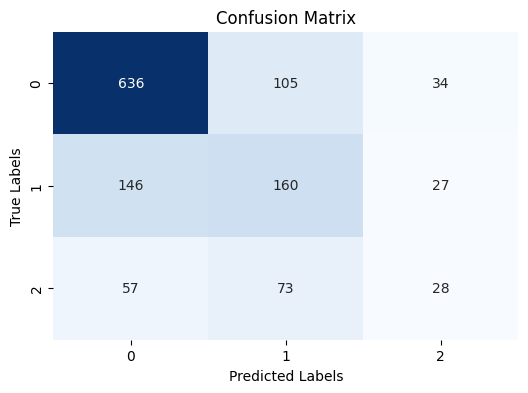


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 636/775 (82.06%)
Class 1: Correct Predictions / Total True Samples = 160/333 (48.05%)
Class 2: Correct Predictions / Total True Samples = 28/158 (17.72%)

Precision-Recall Curves:


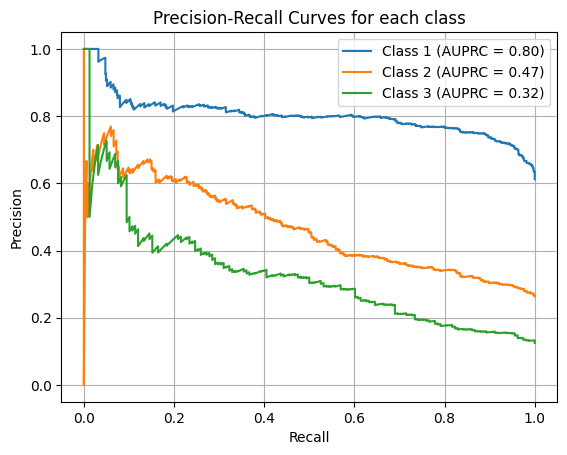


ROC Curves:


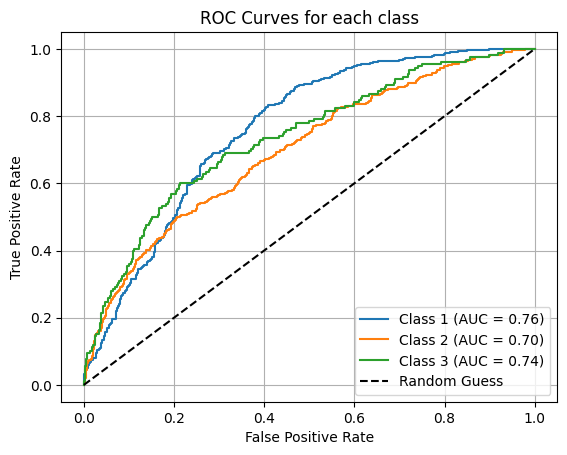


Mean F1 Score: 0.4972
Balanced Accuracy: 0.4928
Average AUPRC: 0.5300

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       775
           1       0.47      0.48      0.48       333
           2       0.31      0.18      0.23       158

    accuracy                           0.65      1266
   macro avg       0.52      0.49      0.50      1266
weighted avg       0.63      0.65      0.64      1266

__________________________________________________
Fold No: 3
training on folds: [[np.int64(1), np.int64(0), np.int64(3)]]
validation on folds: 4
test on folds: 2
Epoch [1/100], Loss: 1.0912, Accuracy: 0.4097 | Validation Loss: 1.1099, Validation Accuracy: 0.3920
Epoch [2/100], Loss: 1.0748, Accuracy: 0.4582 | Validation Loss: 1.0894, Validation Accuracy: 0.4226
Epoch [3/100], Loss: 1.0606, Accuracy: 0.4699 | Validation Loss: 1.0309, Validation Accuracy: 0.4429
Epoch [4/100], Loss: 1.0480, Accuracy: 0.5085 | Validation

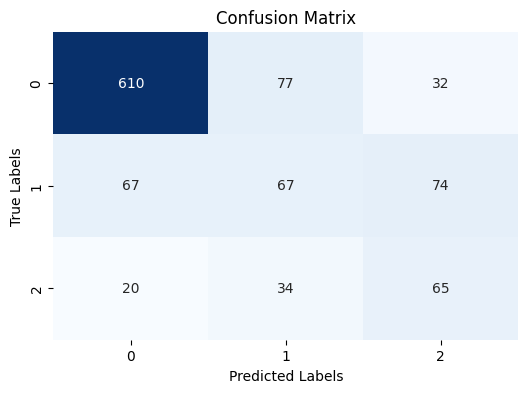


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 610/719 (84.84%)
Class 1: Correct Predictions / Total True Samples = 67/208 (32.21%)
Class 2: Correct Predictions / Total True Samples = 65/119 (54.62%)

Precision-Recall Curves:


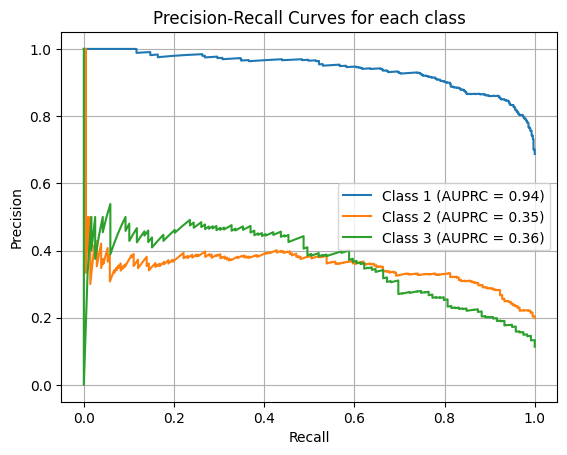


ROC Curves:


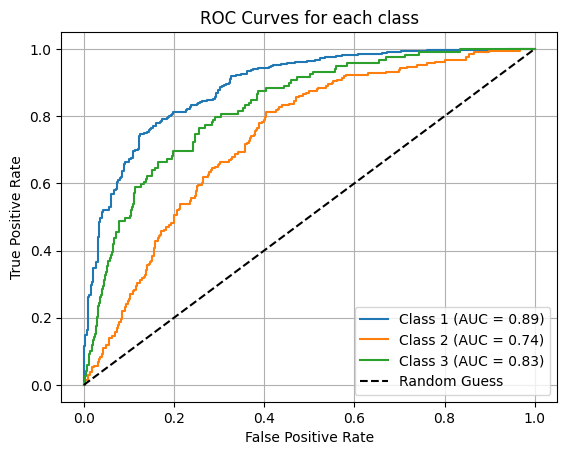


Mean F1 Score: 0.5523
Balanced Accuracy: 0.5722
Average AUPRC: 0.5521

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       719
           1       0.38      0.32      0.35       208
           2       0.38      0.55      0.45       119

    accuracy                           0.71      1046
   macro avg       0.54      0.57      0.55      1046
weighted avg       0.72      0.71      0.71      1046

__________________________________________________
Fold No: 4
training on folds: [[np.int64(1), np.int64(4), np.int64(3)]]
validation on folds: 2
test on folds: 0
Epoch [1/100], Loss: 1.0954, Accuracy: 0.3703 | Validation Loss: 1.0600, Validation Accuracy: 0.4096
Epoch [2/100], Loss: 1.0768, Accuracy: 0.4326 | Validation Loss: 1.0465, Validation Accuracy: 0.4558
Epoch [3/100], Loss: 1.0586, Accuracy: 0.4949 | Validation Loss: 1.0480, Validation Accuracy: 0.4661
Epoch [4/100], Loss: 1.0484, Accuracy: 0.5051 | Validation

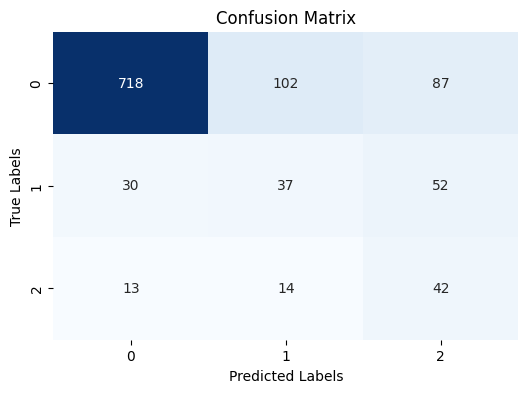


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 718/907 (79.16%)
Class 1: Correct Predictions / Total True Samples = 37/119 (31.09%)
Class 2: Correct Predictions / Total True Samples = 42/69 (60.87%)

Precision-Recall Curves:


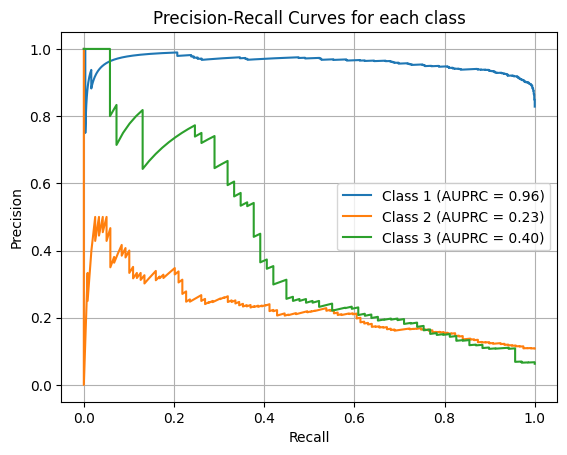


ROC Curves:


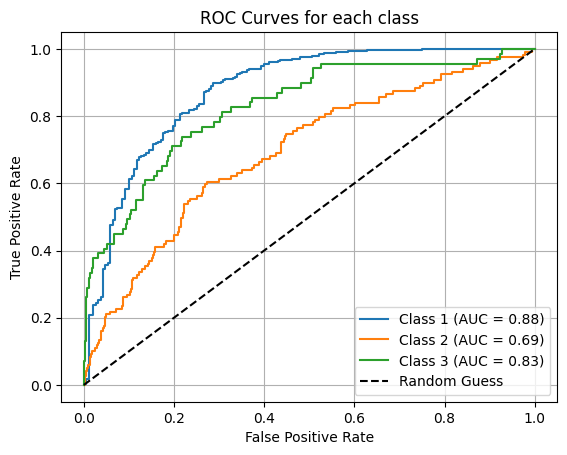


Mean F1 Score: 0.4897
Balanced Accuracy: 0.5704
Average AUPRC: 0.5294

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.79      0.86       907
           1       0.24      0.31      0.27       119
           2       0.23      0.61      0.34        69

    accuracy                           0.73      1095
   macro avg       0.47      0.57      0.49      1095
weighted avg       0.82      0.73      0.76      1095

__________________________________________________
Fold No: 5
training on folds: [[np.int64(1), np.int64(4), np.int64(2)]]
validation on folds: 0
test on folds: 3
Epoch [1/100], Loss: 1.0989, Accuracy: 0.3591 | Validation Loss: 1.0936, Validation Accuracy: 0.4378
Epoch [2/100], Loss: 1.0898, Accuracy: 0.3794 | Validation Loss: 1.1134, Validation Accuracy: 0.4217
Epoch [3/100], Loss: 1.0754, Accuracy: 0.4254 | Validation Loss: 1.0231, Validation Accuracy: 0.4817
Epoch [4/100], Loss: 1.0630, Accuracy: 0.4926 | Validation

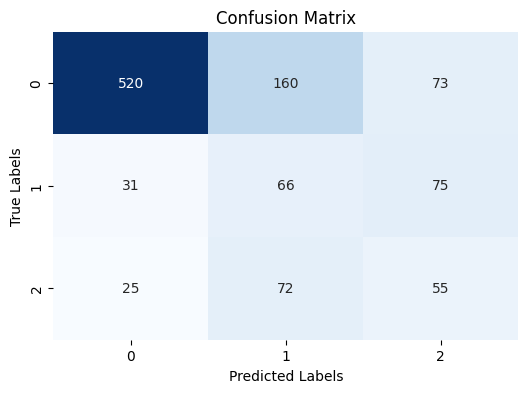


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 520/753 (69.06%)
Class 1: Correct Predictions / Total True Samples = 66/172 (38.37%)
Class 2: Correct Predictions / Total True Samples = 55/152 (36.18%)

Precision-Recall Curves:


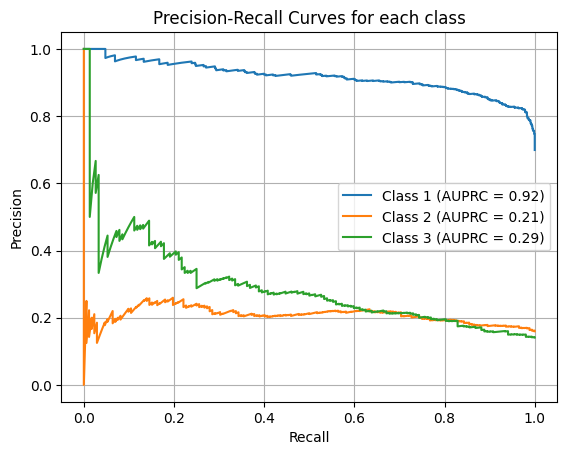


ROC Curves:


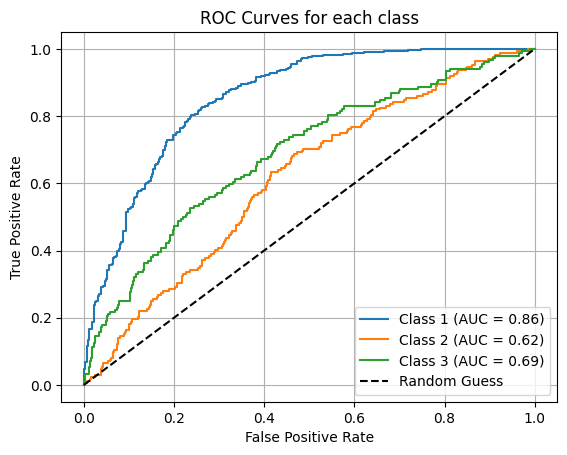


Mean F1 Score: 0.4578
Balanced Accuracy: 0.4787
Average AUPRC: 0.4705

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.69      0.78       753
           1       0.22      0.38      0.28       172
           2       0.27      0.36      0.31       152

    accuracy                           0.60      1077
   macro avg       0.47      0.48      0.46      1077
weighted avg       0.70      0.60      0.64      1077

Accuracy for each fold: [np.float64(0.6094755911517925), np.float64(0.49278027721474027), np.float64(0.5722448094461922), np.float64(0.5704135831984872), np.float64(0.47871136154416744)]
AUPRC for each fold: [np.float64(0.6293421719357254), np.float64(0.5299711373502675), np.float64(0.5521127161655761), np.float64(0.5293587690081816), np.float64(0.4704649697367514)]
Average AUPRC across all folds: 0.5422499528393004
Average Balanced Accuracy across all folds: 0.544725124511076
Results saved to D:\PYTHONIG\newwindow\NOT

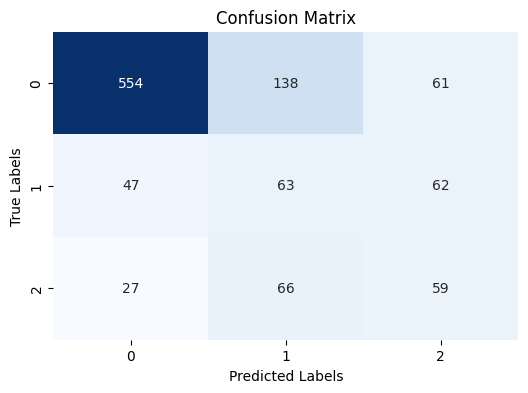


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 554/753 (73.57%)
Class 1: Correct Predictions / Total True Samples = 63/172 (36.63%)
Class 2: Correct Predictions / Total True Samples = 59/152 (38.82%)

Precision-Recall Curves:


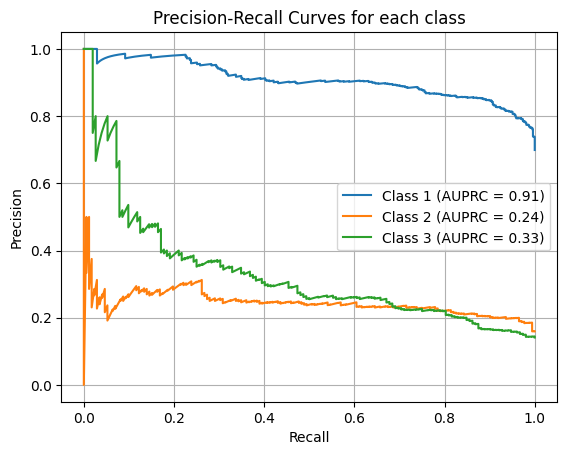


ROC Curves:


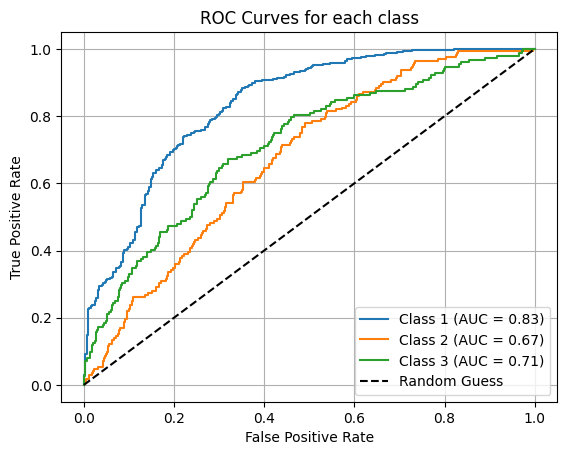


Mean F1 Score: 0.4809
Balanced Accuracy: 0.4967
Average AUPRC: 0.4928

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.74      0.80       753
           1       0.24      0.37      0.29       172
           2       0.32      0.39      0.35       152

    accuracy                           0.63      1077
   macro avg       0.48      0.50      0.48      1077
weighted avg       0.70      0.63      0.66      1077

__________________________________________________
Fold No: 2
training on folds: [[np.int64(2), np.int64(0), np.int64(1)]]
validation on folds: 3
test on folds: 4
Epoch [1/100], Loss: 1.1070, Accuracy: 0.3107 | Validation Loss: 1.1176, Validation Accuracy: 0.3688
Epoch [2/100], Loss: 1.0975, Accuracy: 0.3619 | Validation Loss: 1.1144, Validation Accuracy: 0.3637
Epoch [3/100], Loss: 1.0941, Accuracy: 0.3748 | Validation Loss: 1.0918, Validation Accuracy: 0.4001
Epoch [4/100], Loss: 1.0851, Accuracy: 0.4527 | Validation

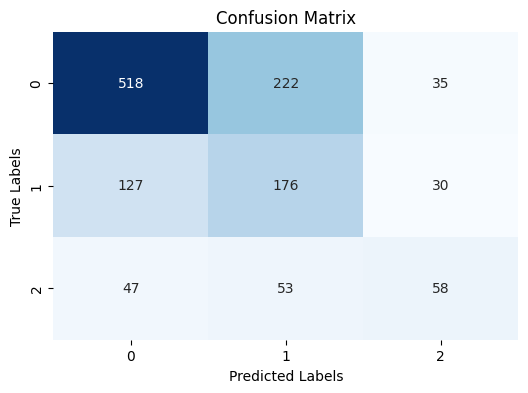


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 518/775 (66.84%)
Class 1: Correct Predictions / Total True Samples = 176/333 (52.85%)
Class 2: Correct Predictions / Total True Samples = 58/158 (36.71%)

Precision-Recall Curves:


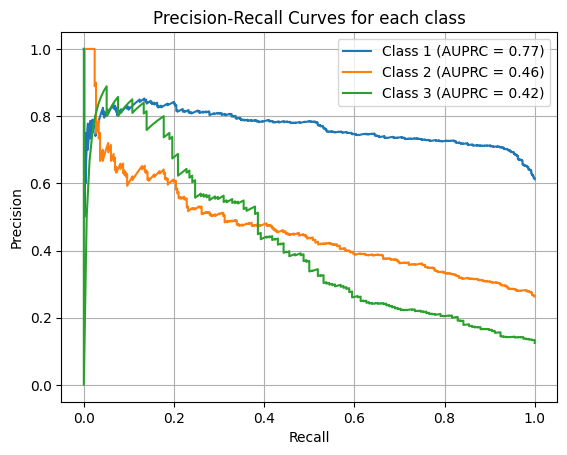


ROC Curves:


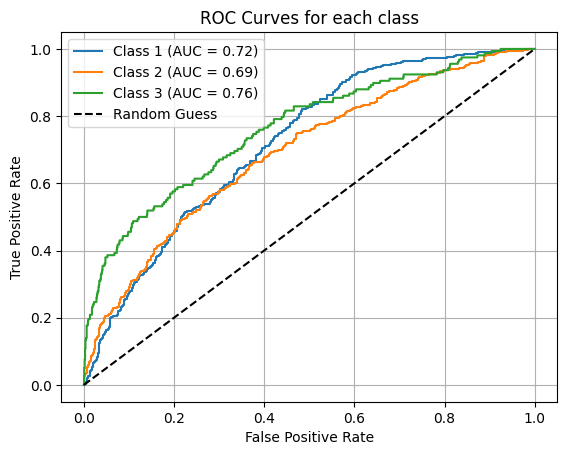


Mean F1 Score: 0.5227
Balanced Accuracy: 0.5213
Average AUPRC: 0.5482

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.67      0.71       775
           1       0.39      0.53      0.45       333
           2       0.47      0.37      0.41       158

    accuracy                           0.59      1266
   macro avg       0.54      0.52      0.52      1266
weighted avg       0.62      0.59      0.60      1266

__________________________________________________
Fold No: 3
training on folds: [[np.int64(3), np.int64(0), np.int64(1)]]
validation on folds: 4
test on folds: 2
Epoch [1/100], Loss: 1.0931, Accuracy: 0.3872 | Validation Loss: 1.0961, Validation Accuracy: 0.3845
Epoch [2/100], Loss: 1.0795, Accuracy: 0.4573 | Validation Loss: 1.0820, Validation Accuracy: 0.4227
Epoch [3/100], Loss: 1.0668, Accuracy: 0.4933 | Validation Loss: 1.1073, Validation Accuracy: 0.3900
Epoch [4/100], Loss: 1.0589, Accuracy: 0.4942 | Validation

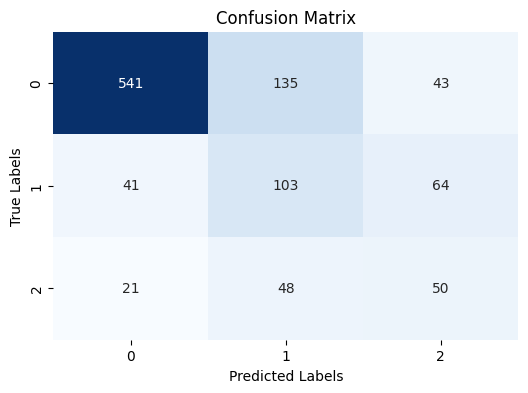


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 541/719 (75.24%)
Class 1: Correct Predictions / Total True Samples = 103/208 (49.52%)
Class 2: Correct Predictions / Total True Samples = 50/119 (42.02%)

Precision-Recall Curves:


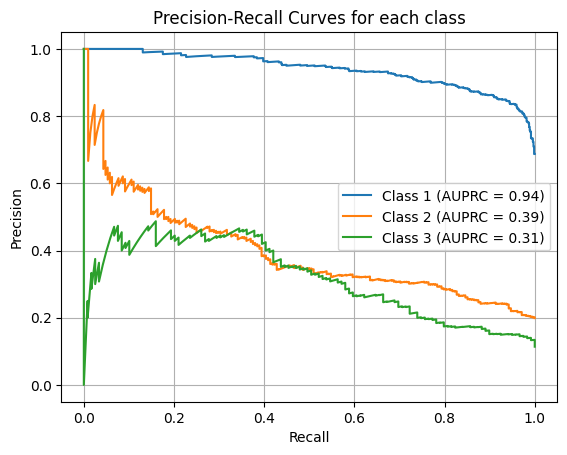


ROC Curves:


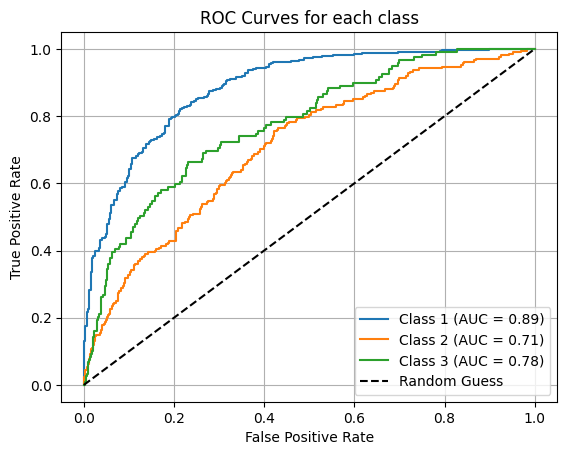


Mean F1 Score: 0.5326
Balanced Accuracy: 0.5559
Average AUPRC: 0.5491

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.75      0.82       719
           1       0.36      0.50      0.42       208
           2       0.32      0.42      0.36       119

    accuracy                           0.66      1046
   macro avg       0.53      0.56      0.53      1046
weighted avg       0.72      0.66      0.69      1046

__________________________________________________
Fold No: 4
training on folds: [[np.int64(3), np.int64(4), np.int64(1)]]
validation on folds: 2
test on folds: 0
Epoch [1/100], Loss: 1.1007, Accuracy: 0.3348 | Validation Loss: 1.1063, Validation Accuracy: 0.3665
Epoch [2/100], Loss: 1.0907, Accuracy: 0.3841 | Validation Loss: 1.0950, Validation Accuracy: 0.3855
Epoch [3/100], Loss: 1.0805, Accuracy: 0.4384 | Validation Loss: 1.0657, Validation Accuracy: 0.4075
Epoch [4/100], Loss: 1.0689, Accuracy: 0.4587 | Validation

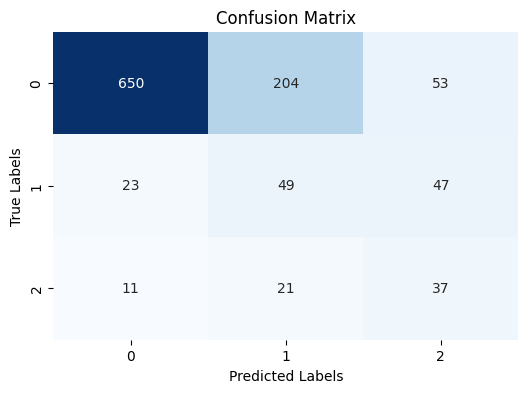


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 650/907 (71.66%)
Class 1: Correct Predictions / Total True Samples = 49/119 (41.18%)
Class 2: Correct Predictions / Total True Samples = 37/69 (53.62%)

Precision-Recall Curves:


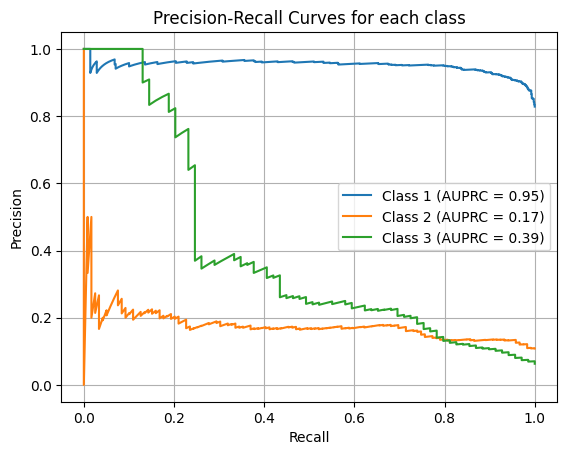


ROC Curves:


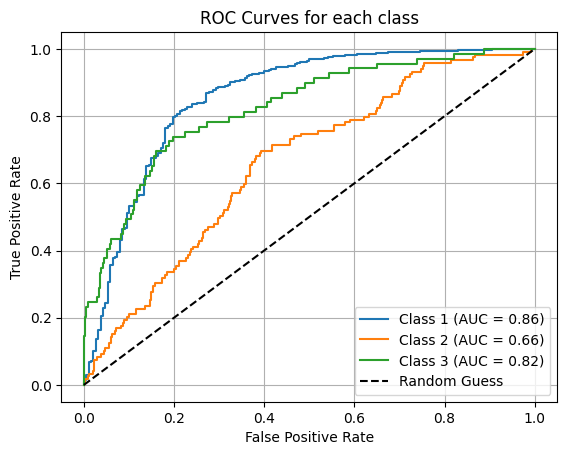


Mean F1 Score: 0.4752
Balanced Accuracy: 0.5549
Average AUPRC: 0.5060

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.72      0.82       907
           1       0.18      0.41      0.25       119
           2       0.27      0.54      0.36        69

    accuracy                           0.67      1095
   macro avg       0.47      0.55      0.48      1095
weighted avg       0.82      0.67      0.73      1095

__________________________________________________
Fold No: 5
training on folds: [[np.int64(3), np.int64(4), np.int64(2)]]
validation on folds: 0
test on folds: 1
Epoch [1/100], Loss: 1.1022, Accuracy: 0.3357 | Validation Loss: 1.1015, Validation Accuracy: 0.4162
Epoch [2/100], Loss: 1.0927, Accuracy: 0.3823 | Validation Loss: 1.1222, Validation Accuracy: 0.4490
Epoch [3/100], Loss: 1.0891, Accuracy: 0.3955 | Validation Loss: 1.0394, Validation Accuracy: 0.5036
Epoch [4/100], Loss: 1.0820, Accuracy: 0.4157 | Validation

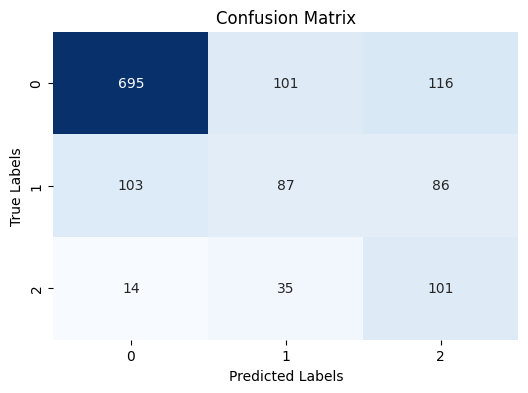


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 695/912 (76.21%)
Class 1: Correct Predictions / Total True Samples = 87/276 (31.52%)
Class 2: Correct Predictions / Total True Samples = 101/150 (67.33%)

Precision-Recall Curves:


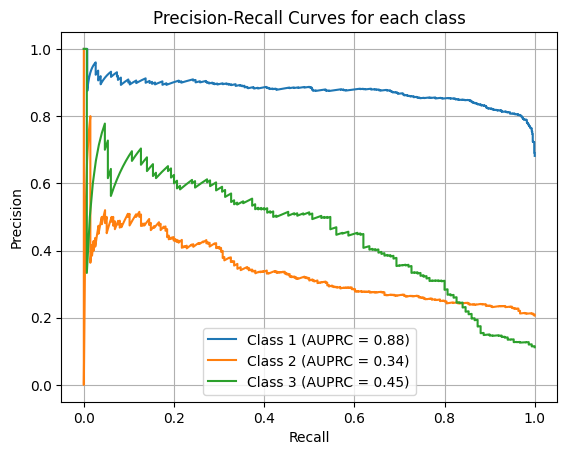


ROC Curves:


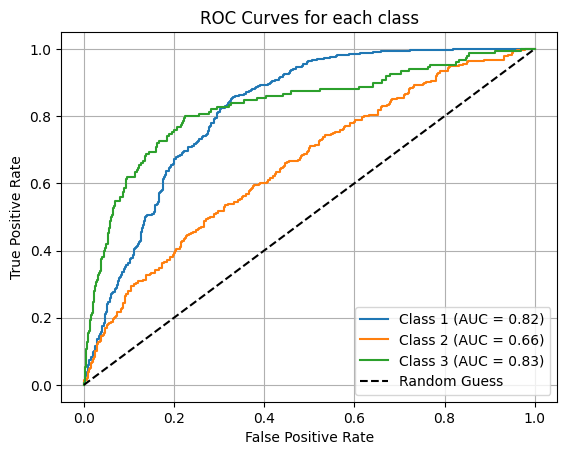


Mean F1 Score: 0.5336
Balanced Accuracy: 0.5835
Average AUPRC: 0.5548

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.76      0.81       912
           1       0.39      0.32      0.35       276
           2       0.33      0.67      0.45       150

    accuracy                           0.66      1338
   macro avg       0.53      0.58      0.53      1338
weighted avg       0.70      0.66      0.67      1338

Accuracy for each fold: [np.float64(0.4967202453615431), np.float64(0.5213347442992196), np.float64(0.5559314369804839), np.float64(0.5548816270032613), np.float64(0.5835373760488177)]
AUPRC for each fold: [np.float64(0.4928335299799138), np.float64(0.5481942472095048), np.float64(0.5491491555248652), np.float64(0.505966250455008), np.float64(0.5548094898511658)]
Average AUPRC across all folds: 0.5301905346040916
Average Balanced Accuracy across all folds: 0.5424810859386651
Results saved to D:\PYTHONIG\newwindow\NOTEB

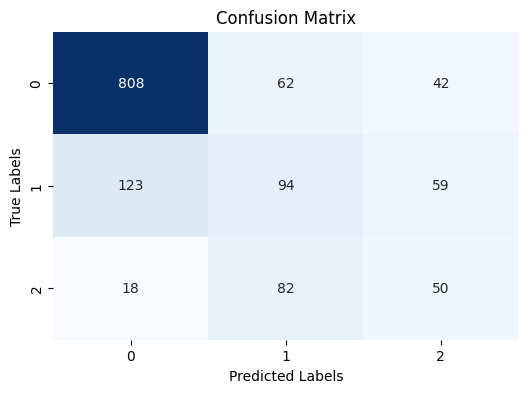


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 808/912 (88.60%)
Class 1: Correct Predictions / Total True Samples = 94/276 (34.06%)
Class 2: Correct Predictions / Total True Samples = 50/150 (33.33%)

Precision-Recall Curves:


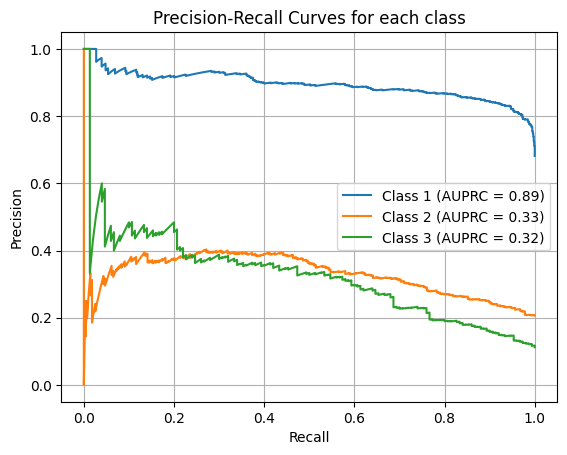


ROC Curves:


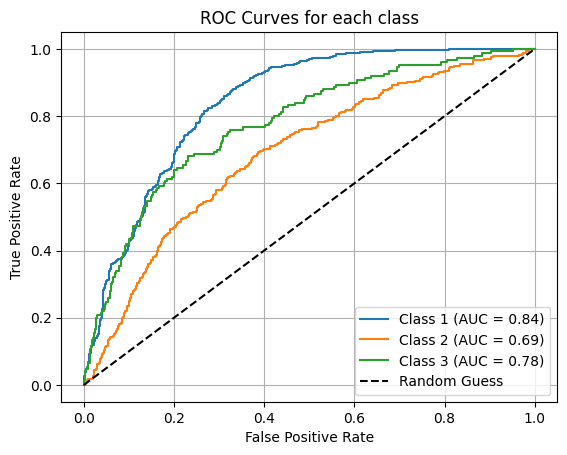


Mean F1 Score: 0.5221
Balanced Accuracy: 0.5200
Average AUPRC: 0.5145

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       912
           1       0.39      0.34      0.37       276
           2       0.33      0.33      0.33       150

    accuracy                           0.71      1338
   macro avg       0.53      0.52      0.52      1338
weighted avg       0.70      0.71      0.70      1338

__________________________________________________
Fold No: 2
training on folds: [[np.int64(0), np.int64(3), np.int64(4)]]
validation on folds: 1
test on folds: 2
Epoch [1/100], Loss: 1.1045, Accuracy: 0.3553 | Validation Loss: 1.0903, Validation Accuracy: 0.4139
Epoch [2/100], Loss: 1.0921, Accuracy: 0.3975 | Validation Loss: 1.0432, Validation Accuracy: 0.4435
Epoch [3/100], Loss: 1.0813, Accuracy: 0.4248 | Validation Loss: 1.0871, Validation Accuracy: 0.4770
Epoch [4/100], Loss: 1.0748, Accuracy: 0.4512 | Validation

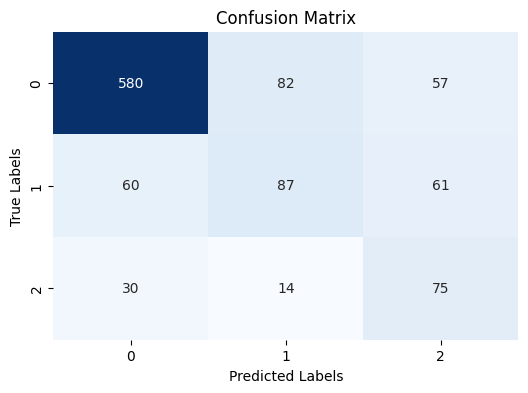


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 580/719 (80.67%)
Class 1: Correct Predictions / Total True Samples = 87/208 (41.83%)
Class 2: Correct Predictions / Total True Samples = 75/119 (63.03%)

Precision-Recall Curves:


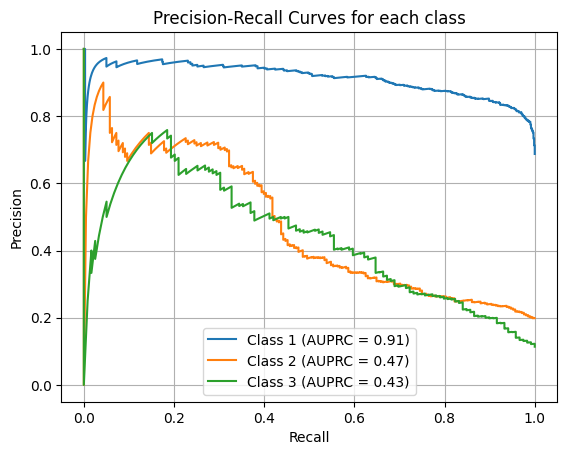


ROC Curves:


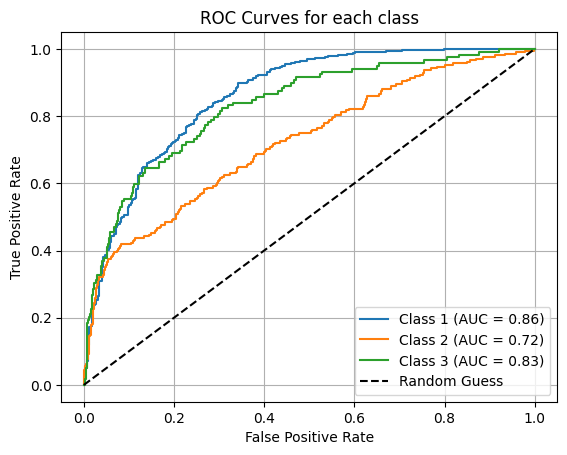


Mean F1 Score: 0.5870
Balanced Accuracy: 0.6184
Average AUPRC: 0.6044

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       719
           1       0.48      0.42      0.45       208
           2       0.39      0.63      0.48       119

    accuracy                           0.71      1046
   macro avg       0.58      0.62      0.59      1046
weighted avg       0.73      0.71      0.72      1046

__________________________________________________
Fold No: 3
training on folds: [[np.int64(1), np.int64(3), np.int64(4)]]
validation on folds: 2
test on folds: 0
Epoch [1/100], Loss: 1.0856, Accuracy: 0.4181 | Validation Loss: 1.1053, Validation Accuracy: 0.3941
Epoch [2/100], Loss: 1.0656, Accuracy: 0.4732 | Validation Loss: 1.0614, Validation Accuracy: 0.4302
Epoch [3/100], Loss: 1.0431, Accuracy: 0.5254 | Validation Loss: 1.0296, Validation Accuracy: 0.4837
Epoch [4/100], Loss: 1.0270, Accuracy: 0.5254 | Validation

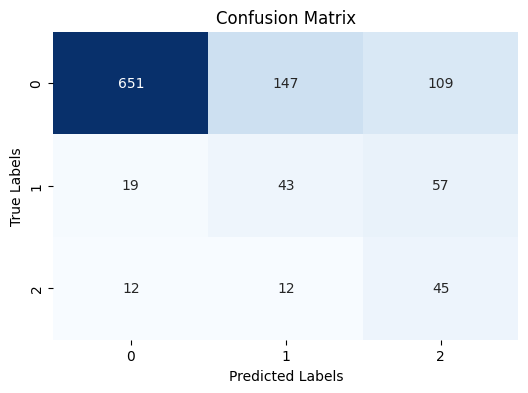


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 651/907 (71.78%)
Class 1: Correct Predictions / Total True Samples = 43/119 (36.13%)
Class 2: Correct Predictions / Total True Samples = 45/69 (65.22%)

Precision-Recall Curves:


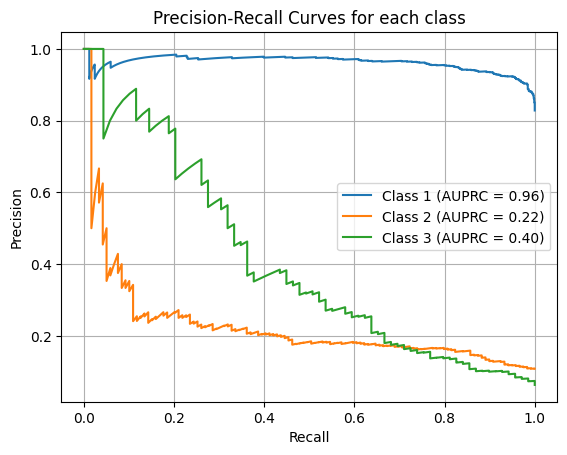


ROC Curves:


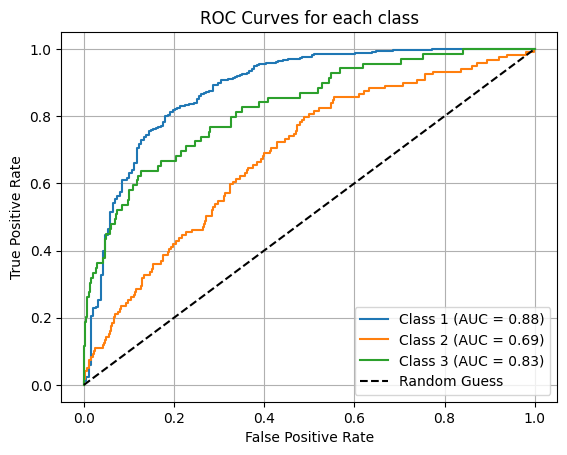


Mean F1 Score: 0.4696
Balanced Accuracy: 0.5771
Average AUPRC: 0.5294

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.72      0.82       907
           1       0.21      0.36      0.27       119
           2       0.21      0.65      0.32        69

    accuracy                           0.67      1095
   macro avg       0.46      0.58      0.47      1095
weighted avg       0.83      0.67      0.73      1095

__________________________________________________
Fold No: 4
training on folds: [[np.int64(1), np.int64(2), np.int64(4)]]
validation on folds: 0
test on folds: 3
Epoch [1/100], Loss: 1.0945, Accuracy: 0.3568 | Validation Loss: 1.0862, Validation Accuracy: 0.4308
Epoch [2/100], Loss: 1.0653, Accuracy: 0.4957 | Validation Loss: 1.0859, Validation Accuracy: 0.4805
Epoch [3/100], Loss: 1.0469, Accuracy: 0.5176 | Validation Loss: 1.0159, Validation Accuracy: 0.5151
Epoch [4/100], Loss: 1.0299, Accuracy: 0.5480 | Validation

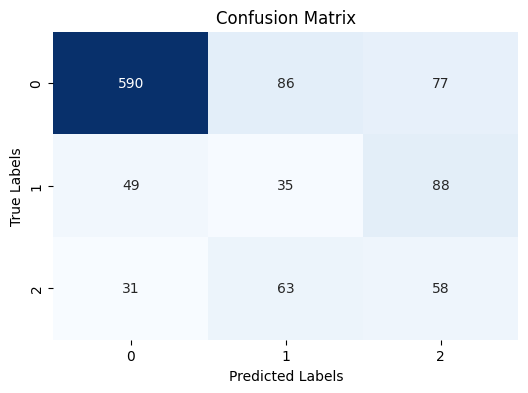


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 590/753 (78.35%)
Class 1: Correct Predictions / Total True Samples = 35/172 (20.35%)
Class 2: Correct Predictions / Total True Samples = 58/152 (38.16%)

Precision-Recall Curves:


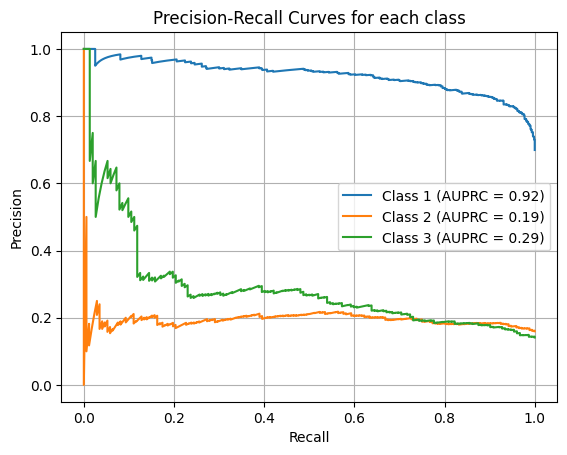


ROC Curves:


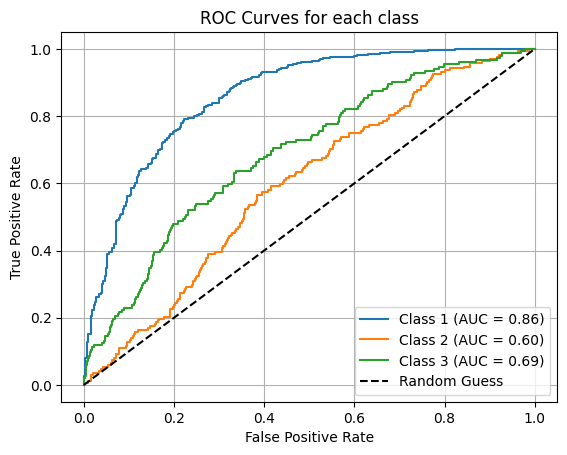


Mean F1 Score: 0.4451
Balanced Accuracy: 0.4562
Average AUPRC: 0.4665

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.83       753
           1       0.19      0.20      0.20       172
           2       0.26      0.38      0.31       152

    accuracy                           0.63      1077
   macro avg       0.44      0.46      0.45      1077
weighted avg       0.68      0.63      0.65      1077

__________________________________________________
Fold No: 5
training on folds: [[np.int64(1), np.int64(2), np.int64(0)]]
validation on folds: 3
test on folds: 4
Epoch [1/100], Loss: 1.0931, Accuracy: 0.3984 | Validation Loss: 1.0490, Validation Accuracy: 0.3987
Epoch [2/100], Loss: 1.0711, Accuracy: 0.4675 | Validation Loss: 1.0529, Validation Accuracy: 0.3921
Epoch [3/100], Loss: 1.0547, Accuracy: 0.4970 | Validation Loss: 1.0464, Validation Accuracy: 0.4016
Epoch [4/100], Loss: 1.0415, Accuracy: 0.5128 | Validation

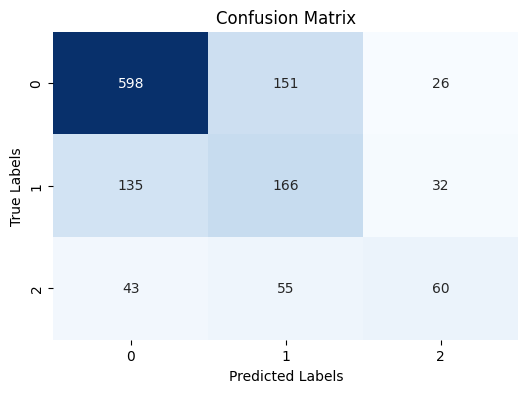


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 598/775 (77.16%)
Class 1: Correct Predictions / Total True Samples = 166/333 (49.85%)
Class 2: Correct Predictions / Total True Samples = 60/158 (37.97%)

Precision-Recall Curves:


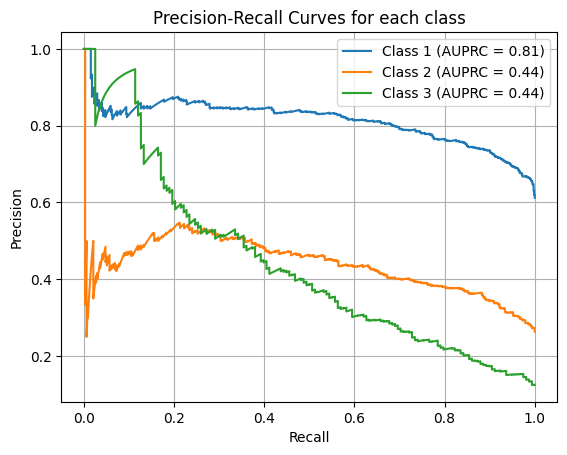


ROC Curves:


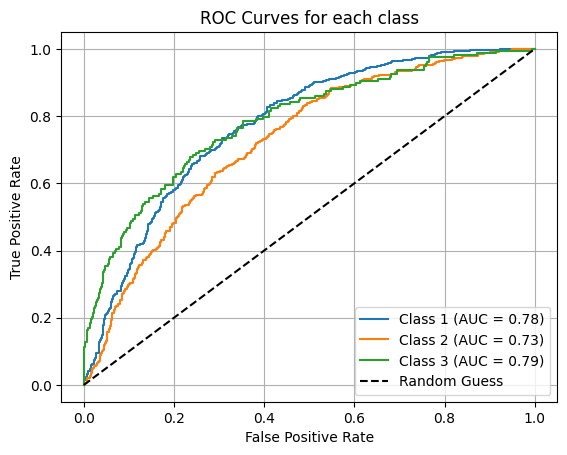


Mean F1 Score: 0.5589
Balanced Accuracy: 0.5500
Average AUPRC: 0.5624

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       775
           1       0.45      0.50      0.47       333
           2       0.51      0.38      0.43       158

    accuracy                           0.65      1266
   macro avg       0.58      0.55      0.56      1266
weighted avg       0.65      0.65      0.65      1266

Accuracy for each fold: [np.float64(0.5199593185863208), np.float64(0.6183990901378204), np.float64(0.5770897592534928), np.float64(0.4561999519940096), np.float64(0.5499527457224477)]
AUPRC for each fold: [np.float64(0.5145066636084256), np.float64(0.6043881390018656), np.float64(0.5293995753273513), np.float64(0.466495210610778), np.float64(0.5623545216297955)]
Average AUPRC across all folds: 0.5354288220356431
Average Balanced Accuracy across all folds: 0.5443201731388182
Results saved to D:\PYTHONIG\newwindow\NOTEB

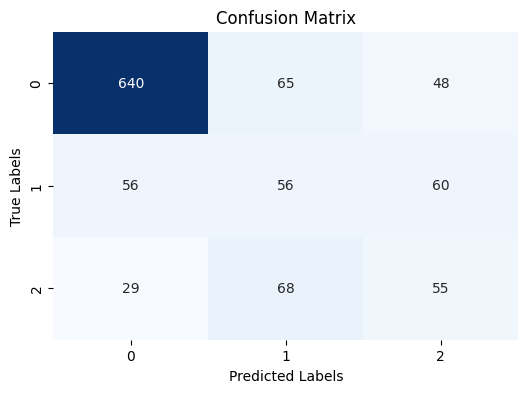


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 640/753 (84.99%)
Class 1: Correct Predictions / Total True Samples = 56/172 (32.56%)
Class 2: Correct Predictions / Total True Samples = 55/152 (36.18%)

Precision-Recall Curves:


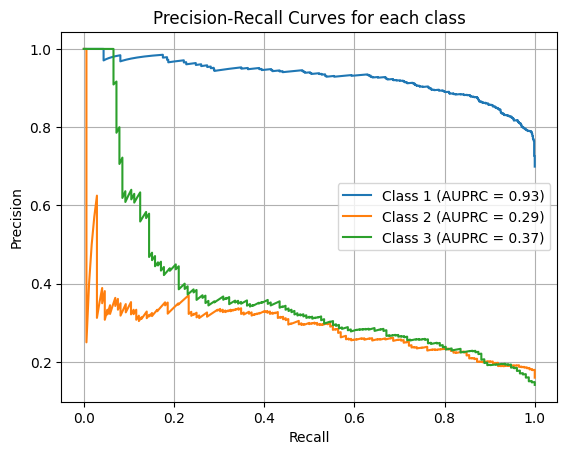


ROC Curves:


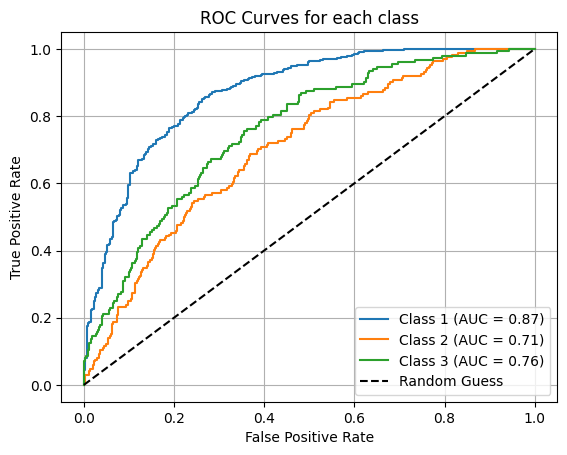


Mean F1 Score: 0.5085
Balanced Accuracy: 0.5125
Average AUPRC: 0.5300

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87       753
           1       0.30      0.33      0.31       172
           2       0.34      0.36      0.35       152

    accuracy                           0.70      1077
   macro avg       0.51      0.51      0.51      1077
weighted avg       0.71      0.70      0.70      1077

__________________________________________________
Fold No: 2
training on folds: [[np.int64(2), np.int64(0), np.int64(4)]]
validation on folds: 3
test on folds: 1
Epoch [1/100], Loss: 1.1021, Accuracy: 0.3468 | Validation Loss: 1.1084, Validation Accuracy: 0.3718
Epoch [2/100], Loss: 1.0947, Accuracy: 0.3748 | Validation Loss: 1.1061, Validation Accuracy: 0.3964
Epoch [3/100], Loss: 1.0903, Accuracy: 0.3988 | Validation Loss: 1.0816, Validation Accuracy: 0.4265
Epoch [4/100], Loss: 1.0829, Accuracy: 0.4268 | Validation

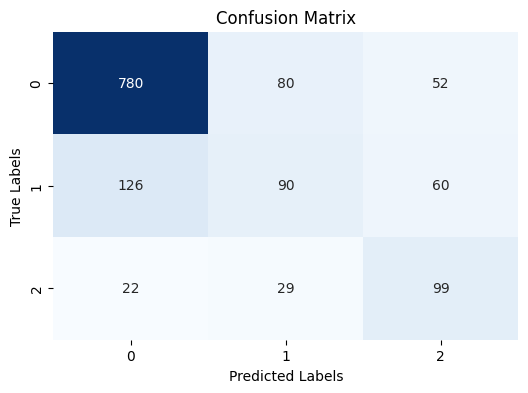


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 780/912 (85.53%)
Class 1: Correct Predictions / Total True Samples = 90/276 (32.61%)
Class 2: Correct Predictions / Total True Samples = 99/150 (66.00%)

Precision-Recall Curves:


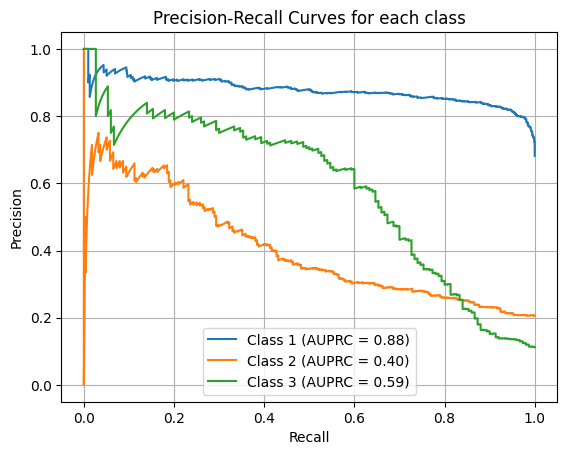


ROC Curves:


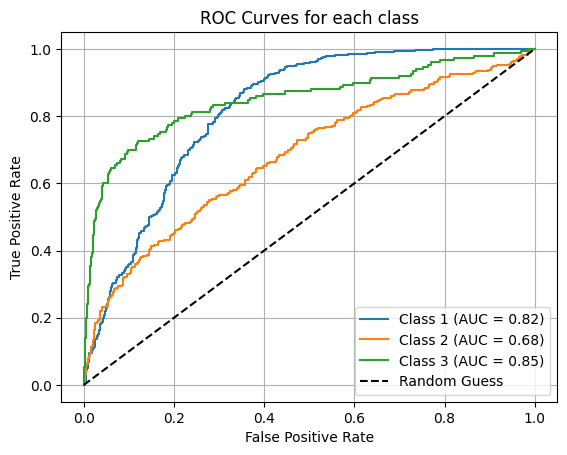


Mean F1 Score: 0.5917
Balanced Accuracy: 0.6138
Average AUPRC: 0.6213

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       912
           1       0.45      0.33      0.38       276
           2       0.47      0.66      0.55       150

    accuracy                           0.72      1338
   macro avg       0.59      0.61      0.59      1338
weighted avg       0.72      0.72      0.72      1338

__________________________________________________
Fold No: 3
training on folds: [[np.int64(3), np.int64(0), np.int64(4)]]
validation on folds: 1
test on folds: 2
Epoch [1/100], Loss: 1.1027, Accuracy: 0.3615 | Validation Loss: 1.0966, Validation Accuracy: 0.3858
Epoch [2/100], Loss: 1.0951, Accuracy: 0.3755 | Validation Loss: 1.1153, Validation Accuracy: 0.4219
Epoch [3/100], Loss: 1.0927, Accuracy: 0.3958 | Validation Loss: 1.0882, Validation Accuracy: 0.4571
Epoch [4/100], Loss: 1.0862, Accuracy: 0.4125 | Validation

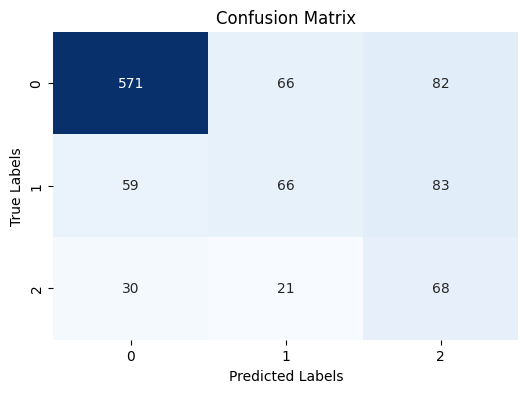


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 571/719 (79.42%)
Class 1: Correct Predictions / Total True Samples = 66/208 (31.73%)
Class 2: Correct Predictions / Total True Samples = 68/119 (57.14%)

Precision-Recall Curves:


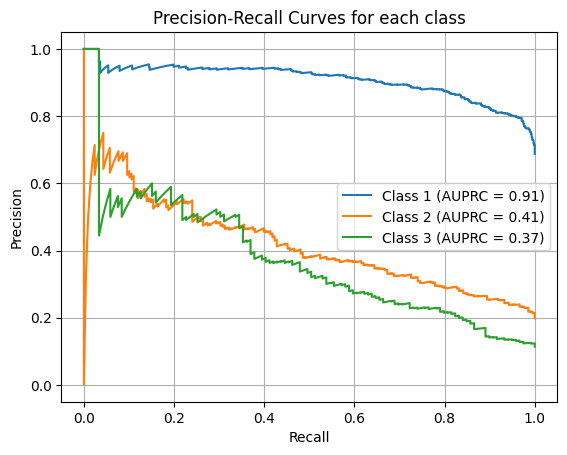


ROC Curves:


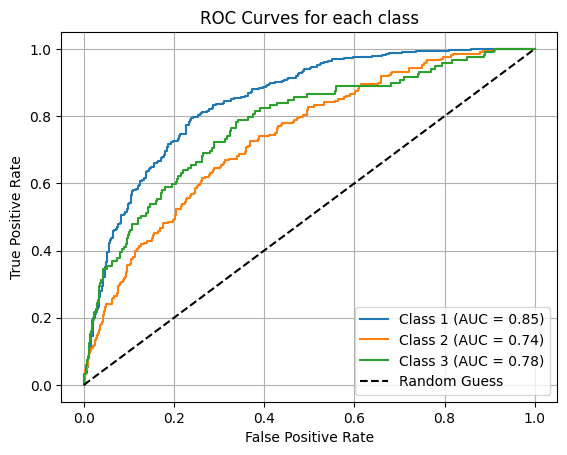


Mean F1 Score: 0.5267
Balanced Accuracy: 0.5610
Average AUPRC: 0.5633

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.79      0.83       719
           1       0.43      0.32      0.37       208
           2       0.29      0.57      0.39       119

    accuracy                           0.67      1046
   macro avg       0.53      0.56      0.53      1046
weighted avg       0.71      0.67      0.69      1046

__________________________________________________
Fold No: 4
training on folds: [[np.int64(3), np.int64(1), np.int64(4)]]
validation on folds: 2
test on folds: 0
Epoch [1/100], Loss: 1.1019, Accuracy: 0.3319 | Validation Loss: 1.0889, Validation Accuracy: 0.3591
Epoch [2/100], Loss: 1.0898, Accuracy: 0.3783 | Validation Loss: 1.0568, Validation Accuracy: 0.4057
Epoch [3/100], Loss: 1.0802, Accuracy: 0.4290 | Validation Loss: 1.0372, Validation Accuracy: 0.4440
Epoch [4/100], Loss: 1.0702, Accuracy: 0.4623 | Validation

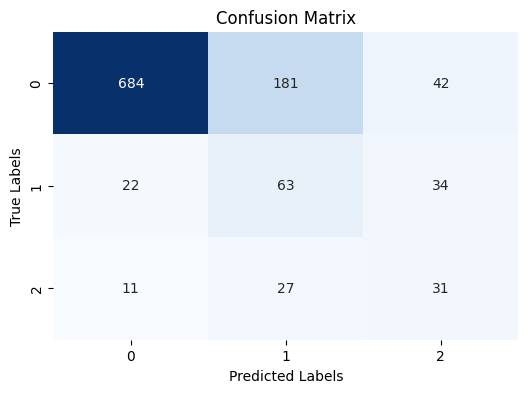


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 684/907 (75.41%)
Class 1: Correct Predictions / Total True Samples = 63/119 (52.94%)
Class 2: Correct Predictions / Total True Samples = 31/69 (44.93%)

Precision-Recall Curves:


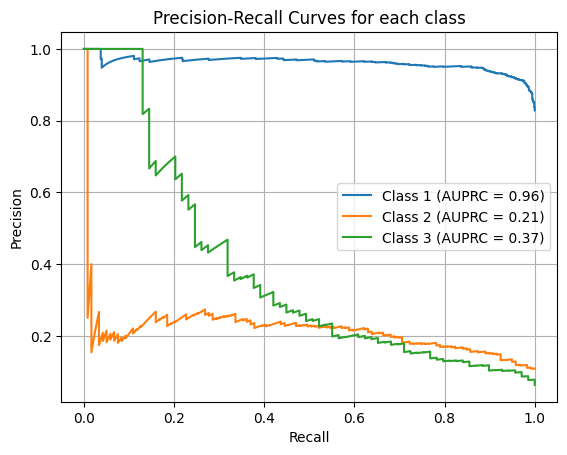


ROC Curves:


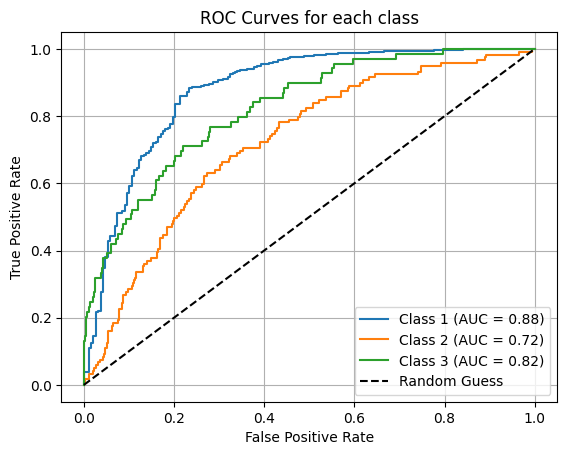


Mean F1 Score: 0.5059
Balanced Accuracy: 0.5776
Average AUPRC: 0.5167

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.75      0.84       907
           1       0.23      0.53      0.32       119
           2       0.29      0.45      0.35        69

    accuracy                           0.71      1095
   macro avg       0.49      0.58      0.51      1095
weighted avg       0.83      0.71      0.76      1095

__________________________________________________
Fold No: 5
training on folds: [[np.int64(3), np.int64(1), np.int64(2)]]
validation on folds: 0
test on folds: 4
Epoch [1/100], Loss: 1.1044, Accuracy: 0.3492 | Validation Loss: 1.0606, Validation Accuracy: 0.4115
Epoch [2/100], Loss: 1.0931, Accuracy: 0.3967 | Validation Loss: 1.0904, Validation Accuracy: 0.4288
Epoch [3/100], Loss: 1.0878, Accuracy: 0.4046 | Validation Loss: 1.0588, Validation Accuracy: 0.4725
Epoch [4/100], Loss: 1.0791, Accuracy: 0.4101 | Validation

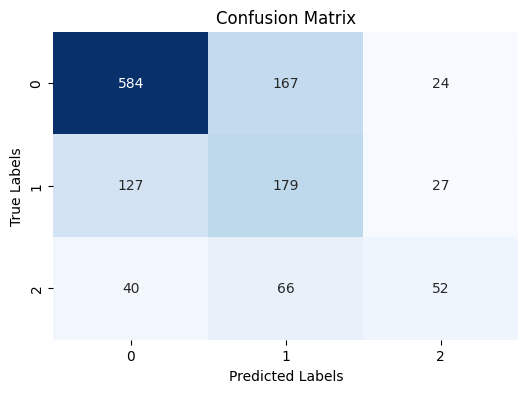


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 584/775 (75.35%)
Class 1: Correct Predictions / Total True Samples = 179/333 (53.75%)
Class 2: Correct Predictions / Total True Samples = 52/158 (32.91%)

Precision-Recall Curves:


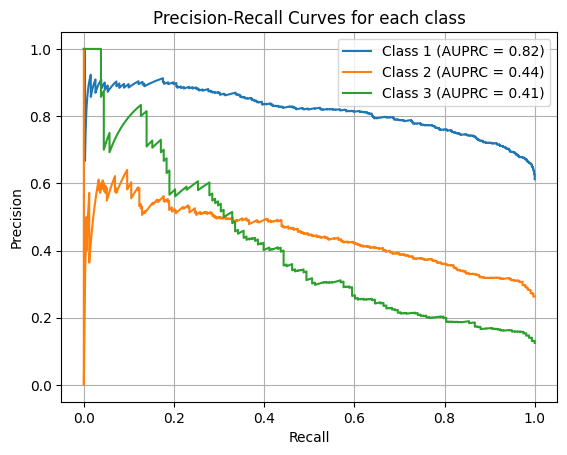


ROC Curves:


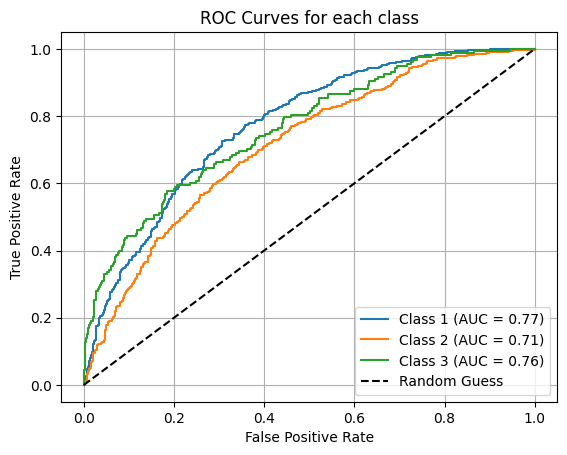


Mean F1 Score: 0.5481
Balanced Accuracy: 0.5401
Average AUPRC: 0.5566

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.75      0.77       775
           1       0.43      0.54      0.48       333
           2       0.50      0.33      0.40       158

    accuracy                           0.64      1266
   macro avg       0.57      0.54      0.55      1266
weighted avg       0.65      0.64      0.64      1266

Accuracy for each fold: [np.float64(0.512452366516526), np.float64(0.6137833714721587), np.float64(0.5609649390942854), np.float64(0.5776072121320925), np.float64(0.5400666162283149)]
AUPRC for each fold: [np.float64(0.5299616587955699), np.float64(0.6213122296512696), np.float64(0.5632856675517054), np.float64(0.5166570569518585), np.float64(0.5565645203195212)]
Average AUPRC across all folds: 0.5575562266539849
Average Balanced Accuracy across all folds: 0.5609749010886755
Results saved to D:\PYTHONIG\newwindow\NOTEB

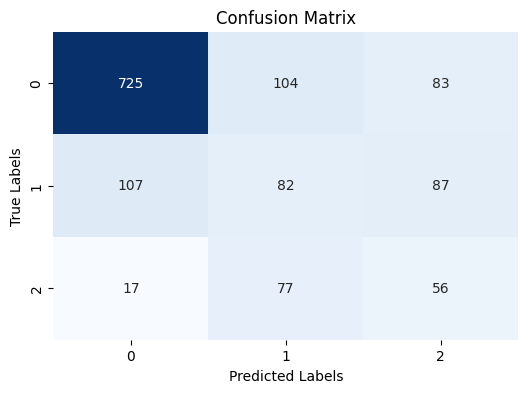


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 725/912 (79.50%)
Class 1: Correct Predictions / Total True Samples = 82/276 (29.71%)
Class 2: Correct Predictions / Total True Samples = 56/150 (37.33%)

Precision-Recall Curves:


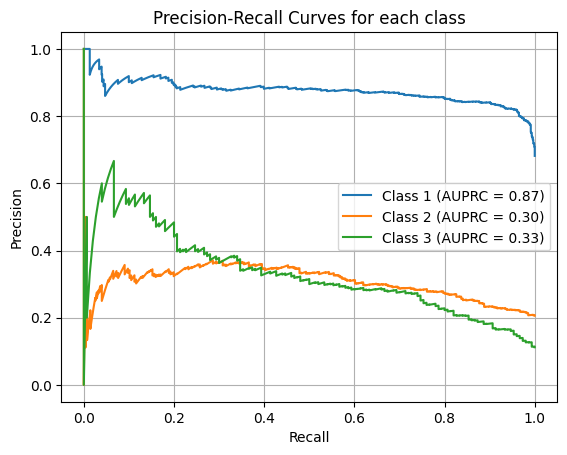


ROC Curves:


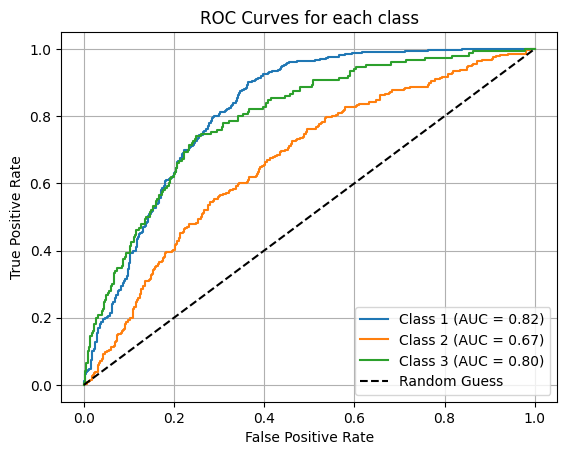


Mean F1 Score: 0.4752
Balanced Accuracy: 0.4885
Average AUPRC: 0.5030

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82       912
           1       0.31      0.30      0.30       276
           2       0.25      0.37      0.30       150

    accuracy                           0.64      1338
   macro avg       0.47      0.49      0.48      1338
weighted avg       0.67      0.64      0.66      1338

__________________________________________________
Fold No: 2
training on folds: [[np.int64(3), np.int64(2), np.int64(4)]]
validation on folds: 1
test on folds: 0
Epoch [1/100], Loss: 1.1070, Accuracy: 0.2883 | Validation Loss: 1.1157, Validation Accuracy: 0.3370
Epoch [2/100], Loss: 1.1036, Accuracy: 0.3023 | Validation Loss: 1.0777, Validation Accuracy: 0.3503
Epoch [3/100], Loss: 1.1007, Accuracy: 0.3287 | Validation Loss: 1.0856, Validation Accuracy: 0.3864
Epoch [4/100], Loss: 1.0994, Accuracy: 0.3504 | Validation

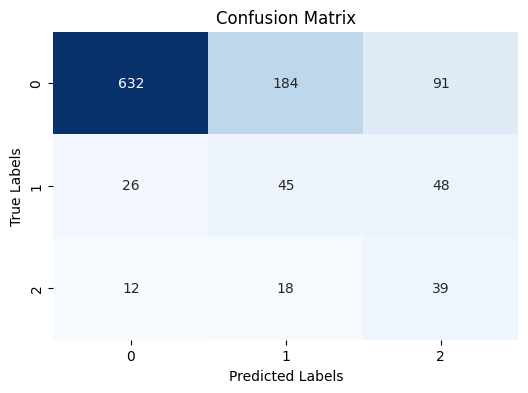


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 632/907 (69.68%)
Class 1: Correct Predictions / Total True Samples = 45/119 (37.82%)
Class 2: Correct Predictions / Total True Samples = 39/69 (56.52%)

Precision-Recall Curves:


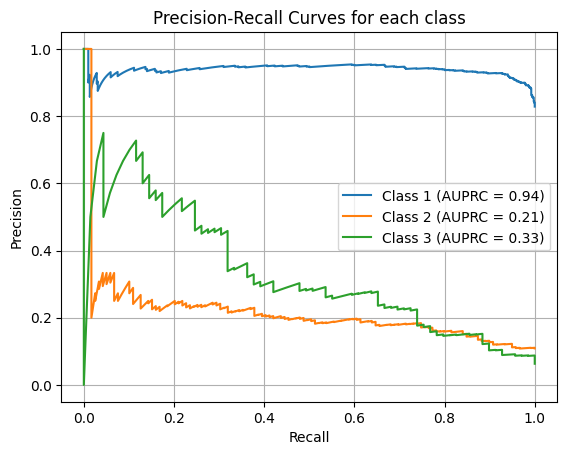


ROC Curves:


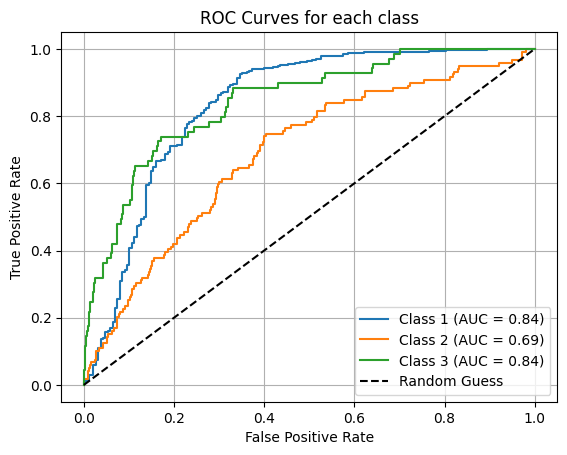


Mean F1 Score: 0.4544
Balanced Accuracy: 0.5467
Average AUPRC: 0.4922

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.70      0.80       907
           1       0.18      0.38      0.25       119
           2       0.22      0.57      0.32        69

    accuracy                           0.65      1095
   macro avg       0.45      0.55      0.45      1095
weighted avg       0.81      0.65      0.71      1095

__________________________________________________
Fold No: 3
training on folds: [[np.int64(1), np.int64(2), np.int64(4)]]
validation on folds: 0
test on folds: 3
Epoch [1/100], Loss: 1.1097, Accuracy: 0.3177 | Validation Loss: 1.1073, Validation Accuracy: 0.3571
Epoch [2/100], Loss: 1.0977, Accuracy: 0.3583 | Validation Loss: 1.0974, Validation Accuracy: 0.4358
Epoch [3/100], Loss: 1.0947, Accuracy: 0.3770 | Validation Loss: 1.0769, Validation Accuracy: 0.4549
Epoch [4/100], Loss: 1.0933, Accuracy: 0.4114 | Validation

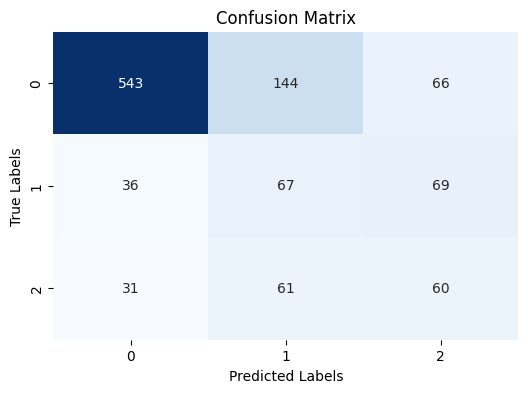


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 543/753 (72.11%)
Class 1: Correct Predictions / Total True Samples = 67/172 (38.95%)
Class 2: Correct Predictions / Total True Samples = 60/152 (39.47%)

Precision-Recall Curves:


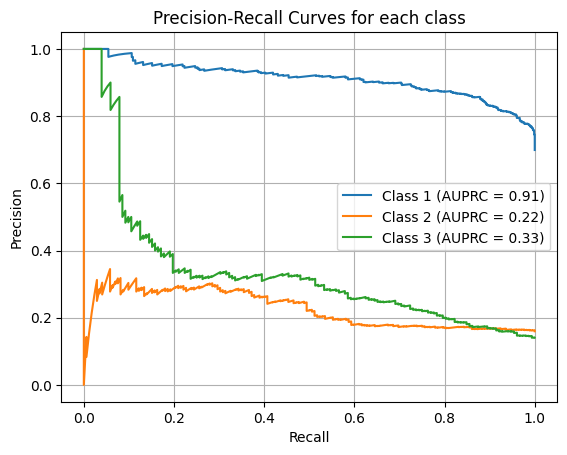


ROC Curves:


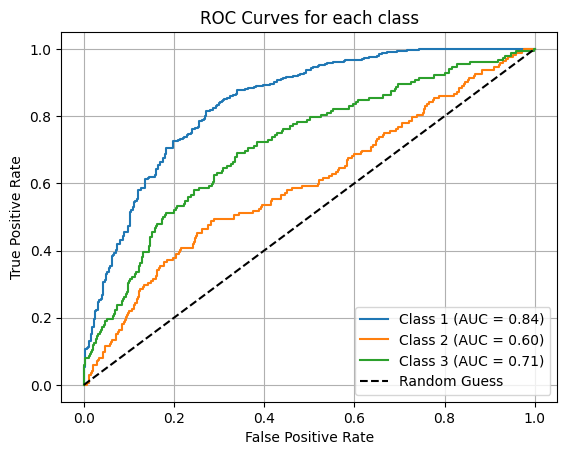


Mean F1 Score: 0.4815
Balanced Accuracy: 0.5018
Average AUPRC: 0.4898

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.72      0.80       753
           1       0.25      0.39      0.30       172
           2       0.31      0.39      0.35       152

    accuracy                           0.62      1077
   macro avg       0.48      0.50      0.48      1077
weighted avg       0.71      0.62      0.65      1077

__________________________________________________
Fold No: 4
training on folds: [[np.int64(1), np.int64(0), np.int64(4)]]
validation on folds: 3
test on folds: 2
Epoch [1/100], Loss: 1.1090, Accuracy: 0.3236 | Validation Loss: 1.0951, Validation Accuracy: 0.2797
Epoch [2/100], Loss: 1.0998, Accuracy: 0.3068 | Validation Loss: 1.1031, Validation Accuracy: 0.3367
Epoch [3/100], Loss: 1.0974, Accuracy: 0.3431 | Validation Loss: 1.0993, Validation Accuracy: 0.3258
Epoch [4/100], Loss: 1.0957, Accuracy: 0.3546 | Validation

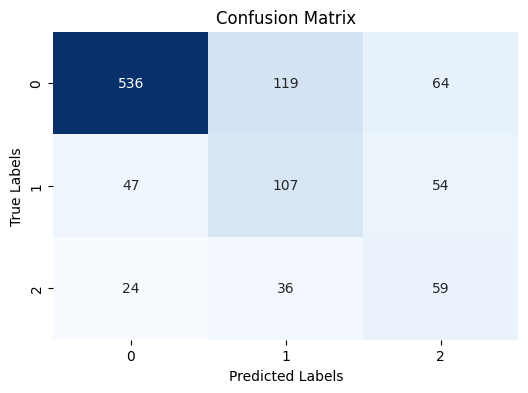


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 536/719 (74.55%)
Class 1: Correct Predictions / Total True Samples = 107/208 (51.44%)
Class 2: Correct Predictions / Total True Samples = 59/119 (49.58%)

Precision-Recall Curves:


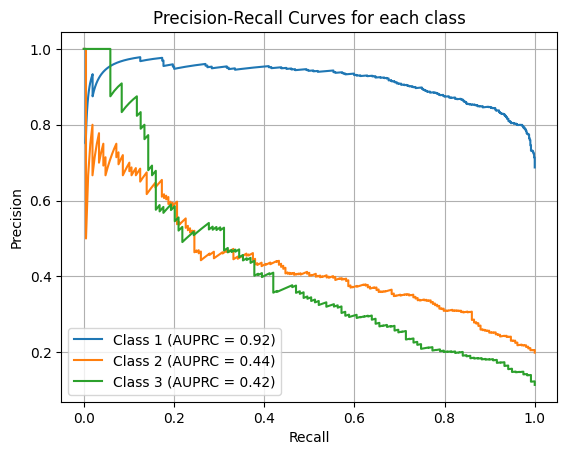


ROC Curves:


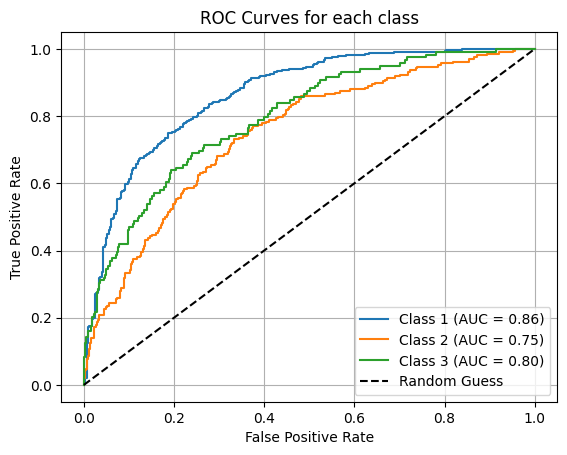


Mean F1 Score: 0.5541
Balanced Accuracy: 0.5852
Average AUPRC: 0.5899

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.75      0.81       719
           1       0.41      0.51      0.46       208
           2       0.33      0.50      0.40       119

    accuracy                           0.67      1046
   macro avg       0.54      0.59      0.55      1046
weighted avg       0.73      0.67      0.69      1046

__________________________________________________
Fold No: 5
training on folds: [[np.int64(1), np.int64(0), np.int64(3)]]
validation on folds: 2
test on folds: 4
Epoch [1/100], Loss: 1.1072, Accuracy: 0.2965 | Validation Loss: 1.0888, Validation Accuracy: 0.3079
Epoch [2/100], Loss: 1.1007, Accuracy: 0.3513 | Validation Loss: 1.1070, Validation Accuracy: 0.3411
Epoch [3/100], Loss: 1.1001, Accuracy: 0.3279 | Validation Loss: 1.0956, Validation Accuracy: 0.3435
Epoch [4/100], Loss: 1.0983, Accuracy: 0.3585 | Validation

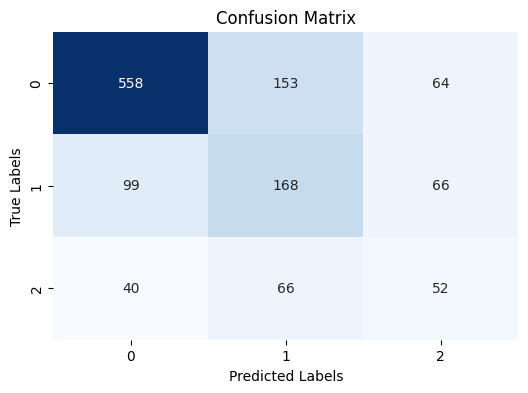


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 558/775 (72.00%)
Class 1: Correct Predictions / Total True Samples = 168/333 (50.45%)
Class 2: Correct Predictions / Total True Samples = 52/158 (32.91%)

Precision-Recall Curves:


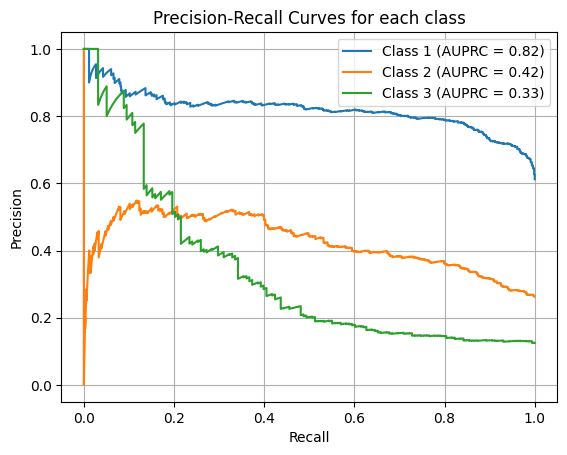


ROC Curves:


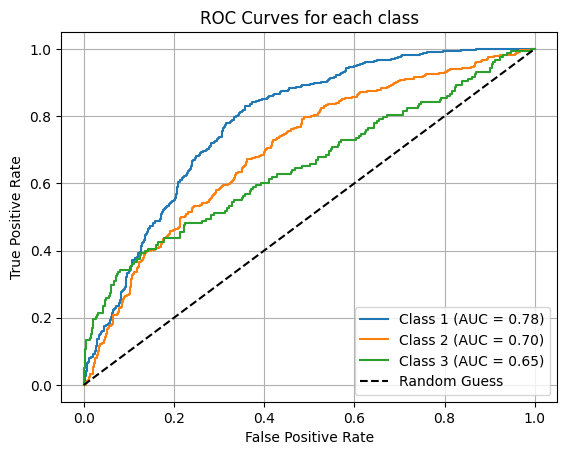


Mean F1 Score: 0.5102
Balanced Accuracy: 0.5179
Average AUPRC: 0.5244

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.72      0.76       775
           1       0.43      0.50      0.47       333
           2       0.29      0.33      0.31       158

    accuracy                           0.61      1266
   macro avg       0.51      0.52      0.51      1266
weighted avg       0.64      0.61      0.63      1266

Accuracy for each fold: [np.float64(0.48846364098652423), np.float64(0.5467237659648491), np.float64(0.5017957545582664), np.float64(0.5852337431174459), np.float64(0.5178728095183791)]
AUPRC for each fold: [np.float64(0.5030408907225636), np.float64(0.4921502650749927), np.float64(0.4897884795037699), np.float64(0.5899386861260718), np.float64(0.5244343033359017)]
Average AUPRC across all folds: 0.5198705249526598
Average Balanced Accuracy across all folds: 0.528017942829093
Results saved to D:\PYTHONIG\newwindow\NOTE

In [12]:

import pandas as pd
import os
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, auc



torch.random.manual_seed(42)  # For reproducibility
np.random.seed(42)  # For reproducibility

all_params = [
{"trial": 22, "accuracy": 0.5544, "params": {"num_heads": 2, "num_transformer_blocks": 2, "learning_rate": 4.304666123970005e-05, "optimizer": "AdamW", "weight_decay": 0.00015485818844352672, "batch_size": 32, "label_smoothing": 0.1}},
{"trial": 17, "accuracy": 0.5437, "params": {"num_heads": 2, "num_transformer_blocks": 8, "learning_rate": 1.939187445679444e-05, "optimizer": "AdamW", "weight_decay": 6.92277004062185e-05, "batch_size": 32, "label_smoothing": 0.16}},
{"trial": 28, "accuracy": 0.5392, "params": {"num_heads": 32, "num_transformer_blocks": 2, "learning_rate": 3.4693506333536474e-05, "optimizer": "AdamW", "weight_decay": 0.00029656663173285, "batch_size": 16, "label_smoothing": 0.07}},
{"trial": 29, "accuracy": 0.5355, "params": {"num_heads": 32, "num_transformer_blocks": 2, "learning_rate": 1.74006045498564e-05, "optimizer": "AdamW", "weight_decay": 0.0003496624190219605, "batch_size": 16, "label_smoothing": 0.01}},
{"trial": 15, "accuracy": 0.5327, "params": {"num_heads": 2, "num_transformer_blocks": 8, "learning_rate": 8.432640395680454e-06, "optimizer": "AdamW", "weight_decay": 6.472847080072849e-05, "batch_size": 32, "label_smoothing": 0.17}}
]

for param_id in range(len(all_params)):

    paramsss = all_params[param_id]
    params = paramsss["params"]
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print(f"PARAMS SET {param_id}")
    print("_"*50)
    print("_"*50)
    print("_"*50)


    # Fold indices and other configurations
    num_folds = 5
    fold_indices = np.random.permutation(np.arange(num_folds))
    val_fold_indices = np.roll(fold_indices, 1)

    test_folds_chosen = []
    val_folds_chosen = []
    fold_confusion_matrices = []  # To store confusion matrices for each fold
    fold_accuracies = []  # To store balanced accuracy for each fold
    fold_auprcs = []  # To store AUPRC for each fold

    # Model and training configurations
    num_classes = 3
    epochs = 100
    input_shape = (3,224,224)
    embed_dim = 128
    num_heads = params['num_heads']
    num_transformer_blocks = params['num_transformer_blocks']
    learning_rate = params['learning_rate']
    optimizer = params['optimizer']
    weight_decay = params['weight_decay']
    batch_size = params['batch_size']

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def save_results_to_csv(fold_accuracies, fold_auprcs, fold_confusion_matrices, model_info, csv_path=r"D:\PYTHONIG\aprilmay2025\newnotebooks\results.csv"):
        """
        Save all results from the current experiment to a CSV file
        
        Parameters:
        - fold_accuracies: list of balanced accuracy scores for each fold
        - fold_auprcs: list of AUPRC scores for each fold
        - fold_confusion_matrices: list of confusion matrices for each fold
        - model_info: string with model architecture description
        - csv_path: path to the CSV file to save results
        """
        # Current time for experiment identification
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        
        # Prepare data for the DataFrame
        data = {
            "timestamp": timestamp,
            "model_info": model_info,
            "num_classes": num_classes,
            "learning_rate": learning_rate,
            "epochs": epochs,
            "mean_balanced_accuracy": np.mean(fold_accuracies),
            "std_balanced_accuracy": np.std(fold_accuracies),
            "mean_auprc": np.mean(fold_auprcs),
            "std_auprc": np.std(fold_auprcs),
        }
        
        # Add individual fold results
        for i, (acc, auprc) in enumerate(zip(fold_accuracies, fold_auprcs)):
            data[f"fold_{i+1}_accuracy"] = acc
            data[f"fold_{i+1}_auprc"] = auprc
        
        # Add confusion matrix info
        for i, cm in enumerate(fold_confusion_matrices):
            data[f"fold_{i+1}_confusion_matrix"] = str(cm)
        
        # Create DataFrame and append to CSV
        df = pd.DataFrame([data])
        
        # Check if file exists
        file_exists = os.path.isfile(csv_path)
        
        # Save to CSV
        if file_exists:
            df.to_csv(csv_path, mode='a', header=False, index=False)
        else:
            df.to_csv(csv_path, mode='w', header=True, index=False)
        
        print(f"Results saved to {csv_path}")
        
    # np.random.seed(42)  # For reproducibility
    # torch.manual_seed(42)  # For reproducibility


    # Training loop for cross-validation
    for fold_idx in range(5):
        
        torch.cuda.empty_cache()
        print("_"*50)
        
        print(f'Fold No: {fold_idx + 1}')
        
        # Initialize model, loss, and optimizer
        fold_model = TRANS_CNN(input_shape=input_shape,num_classes=num_classes,embed_dim=128,num_heads=num_heads,num_transformer_blocks=num_transformer_blocks) # Initialize your model here
        fold_model.to(device)
        
        criterion = nn.CrossEntropyLoss(label_smoothing=0.3)
        optimizer = optim.AdamW(fold_model.parameters(), lr=learning_rate,weight_decay=weight_decay)
        
        # Split data into train, validation, and test sets
        test_fold = fold_indices[fold_idx]
        val_fold = val_fold_indices[fold_idx]
        train_folds = [fold for fold in fold_indices if fold != test_fold and fold != val_fold]
        
        print(f"training on folds: {[train_folds]}")
        print(f"validation on folds: {val_fold}")
        print(f"test on folds: {test_fold}")
        

        train_data = np.concatenate([eeg_folds[j] for j in train_folds])
        train_labels = np.concatenate([labels_folds[j] for j in train_folds])
        train_data = train_data.transpose(0, 3, 1, 2)  # Transpose to match PyTorch input format

        test_folds_chosen.append(test_fold)
        val_folds_chosen.append(val_fold)
        
        early_stopping = EarlyStopping(patience=10)
        
        # Training loop
        for epoch in range(epochs):
            balanced_train_data, balanced_train_labels = data_balancer(train_data, train_labels, factor=1)

            train_dataset = TensorDataset(
                torch.tensor(balanced_train_data, dtype=torch.float32).to(device),
                torch.tensor(balanced_train_labels, dtype=torch.long).to(device)
            )
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            
            fold_model.train()
            running_loss = 0.0
            all_preds = []
            all_labels = []
            
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = fold_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
            epoch_loss = running_loss / len(train_loader)
            epoch_acc = balanced_accuracy_score(all_labels, all_preds)

            # Validation loop
            val_data = eeg_folds[val_fold].transpose(0, 3, 1, 2)
            val_labels = labels_folds[val_fold]
            val_dataset = TensorDataset(
                torch.tensor(val_data, dtype=torch.float32).to(device),
                torch.tensor(val_labels, dtype=torch.long).to(device)
            )
            val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

            fold_model.eval()
            val_loss = 0.0
            val_preds = []
            val_labels_list = []

            with torch.no_grad():
                for val_inputs, val_labels in val_loader:
                    val_outputs = fold_model(val_inputs)
                    loss = criterion(val_outputs, val_labels)
                    val_loss += loss.item()

                    _, val_batch_preds = torch.max(val_outputs, 1)
                    val_preds.extend(val_batch_preds.cpu().numpy())
                    val_labels_list.extend(val_labels.cpu().numpy())

            val_loss /= len(val_loader)
            val_acc = balanced_accuracy_score(val_labels_list, val_preds)
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f} | Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

            early_stopping(val_loss, fold_model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        # Load the best model
        early_stopping.load_best_model(fold_model)

        # Test loop
        test_data = eeg_folds[test_fold].transpose(0, 3, 1, 2)
        test_labels = labels_folds[test_fold]
        test_dataset = TensorDataset(
            torch.tensor(test_data, dtype=torch.float32).to(device),
            torch.tensor(test_labels, dtype=torch.long).to(device)
        )
        test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

        fold_model.eval()
        test_probs = []
        test_preds = []
        test_labels_list = []

        with torch.no_grad():
            for test_inputs, test_labels in test_loader:
                test_outputs = fold_model(test_inputs)
                probabilities = torch.softmax(test_outputs, dim=1)
                test_probs.extend(probabilities.cpu().numpy())
                _, preds = torch.max(probabilities, 1)
                test_preds.extend(preds.cpu().numpy())
                test_labels_list.extend(test_labels.cpu().numpy())

        # Compute metrics
        test_acc = balanced_accuracy_score(test_labels_list, test_preds)
        fold_accuracies.append(test_acc)

        cm = confusion_matrix(test_labels_list, test_preds)
        fold_confusion_matrices.append(cm)

        test_labels_binarized = label_binarize(test_labels_list, classes=np.arange(num_classes))
        test_auprcs = []
        for class_idx in range(num_classes):
            precision, recall, _ = precision_recall_curve(test_labels_binarized[:, class_idx], np.array(test_probs)[:, class_idx])
            auprc = auc(recall, precision)
            test_auprcs.append(auprc)

        mean_test_auprc = np.mean(test_auprcs)
        fold_auprcs.append(mean_test_auprc)

        print(f'Test Fold {fold_idx + 1}, Mean AUPRC: {mean_test_auprc:.4f}, Balanced Accuracy: {test_acc:.4f}')

        # Use the plot_metrics function to visualize metrics
        plot_metrics(np.array(test_labels_list), np.array(test_probs), n_classes=num_classes)

    # Final metrics across all folds
    average_auprc = np.mean(fold_auprcs)
    mean_accuracy = np.mean(fold_accuracies)
    print(f'Accuracy for each fold: {fold_accuracies}')
    print(f'AUPRC for each fold: {fold_auprcs}')
    print(f'Average AUPRC across all folds: {average_auprc}')
    print(f'Average Balanced Accuracy across all folds: {mean_accuracy}')

    # Save all results to CSV
    model_description = f"TRANS_CNN hyper#{param_id+1} CONCAT_UNFIL MANUAL APPROACH 3 classes"
    save_results_to_csv(fold_accuracies, fold_auprcs, fold_confusion_matrices, model_description, csv_path=r"D:\PYTHONIG\newwindow\NOTEBOOKS_2025\aprilmay2025\newnotebooks\results.csv")
